# Prediction_of_H1N1_vaccination
Your task is to predict whether people got H1N1 vaccines using information they shared about their backgrounds, opinions, and health behaviors.



### Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import scipy
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


!pip install pandas-profiling
from pandas_profiling import ProfileReport
from IPython.display import clear_output
!pip install category_encoders
import category_encoders
!pip install autoimpute
from autoimpute.imputations import SingleImputer, MultipleImputer, MiceImputer
clear_output();
%matplotlib inline




In [2]:
train = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train.csv')
target = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train_labels.csv')
test = pd.read_csv('../Prediction_of_H1N1_vaccination/data/test.csv')
submission = pd.read_csv('../Prediction_of_H1N1_vaccination/data/submission.csv')

In [3]:
train.shape, target.shape, test.shape, submission.shape

((42154, 38), (42154, 2), (28104, 38), (28104, 2))

In [4]:
df=pd.concat([train,target],axis=1)
df.shape

(42154, 40)

In [5]:
np.random.seed(42)

### EDA1

##### Pandas Profiling

In [6]:
#ProfileReport(df, title="Pandas Profiling Report", explorative=True)

In [7]:
categorical_encoding_needed=[]

In [8]:
def rdplot(df,column_name,rot=0):
    fig1, axs1 = plt.subplots(figsize=(16,6),nrows=1,ncols=2)
    order=sorted(df[f'{column_name}'].dropna().unique())
    ax1=sns.countplot(x=f'{column_name}', data=df[df['vacc_h1n1_f']==0],ax=axs1[0], order=order)
    ax2=sns.countplot(x=f'{column_name}', data=df[df['vacc_h1n1_f']==1],ax=axs1[1], order=order)
    ax1.tick_params(rotation=rot)
    ax2.tick_params(rotation=rot)
    ax1.set_title(f'category count of {column_name} column when target=0')
    ax2.set_title(f'category count of {column_name} column when target=1')
    
    
    col_sum0=df[df['vacc_h1n1_f']==0].groupby(f'{column_name}').count()['vacc_h1n1_f'].sum()
    col_sum1=df[df['vacc_h1n1_f']==1].groupby(f'{column_name}').count()['vacc_h1n1_f'].sum()
    a=df[df['vacc_h1n1_f']==0].groupby(f'{column_name}').count()['vacc_h1n1_f'].apply(lambda x: x/col_sum0*100)
    b=df[df['vacc_h1n1_f']==1].groupby(f'{column_name}').count()['vacc_h1n1_f'].apply(lambda x: x/col_sum1*100)
    c=(a-b).apply(lambda x: abs(x)).reset_index()
    fig2, axs2 = plt.subplots(figsize=(16,10),nrows=1,ncols=1)
    ax3=sns.barplot(x=f'{column_name}',y='vacc_h1n1_f',data=c,ax=axs2)
    ax3.tick_params(rotation=rot)
    ax3.set_title(f'ratio difference of counts of each categories of "{column_name}" columns by target')
    return

##### vacc_h1n1_f (target)
Whether respondent received H1N1 flu vaccine. (This is the target you need to predict for the competition)   
Qualitative Discrete Binary Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : bool   
Remarks : Imbalanced Data

In [9]:
df['vacc_h1n1_f']=df['vacc_h1n1_f'].replace(1,True).replace(0,False)
print(df['vacc_h1n1_f'].unique())
print(df['vacc_h1n1_f'].describe())

[False  True]
count     42154
unique        2
top       False
freq      32077
Name: vacc_h1n1_f, dtype: object


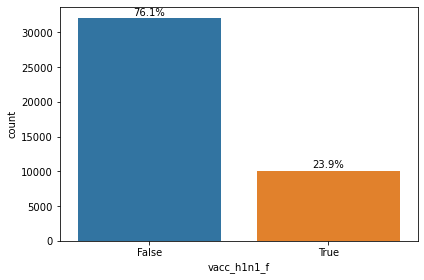

In [10]:
ax=sns.countplot(x='vacc_h1n1_f',data=df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / len(df):.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

##### vacc_seas_f (it's just a dependent variable)
Whether respondent received seasonal flu vaccine.   
Qualitative Discrete Binary Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : bool   
Remarks : this can be used when clustering needed

In [11]:
df['vacc_seas_f']=df['vacc_seas_f'].replace(1,True).replace(0,False)
print(df['vacc_seas_f'].unique())
print(df['vacc_seas_f'].describe())

[False  True]
count     42154
unique        2
top       False
freq      23039
Name: vacc_seas_f, dtype: object


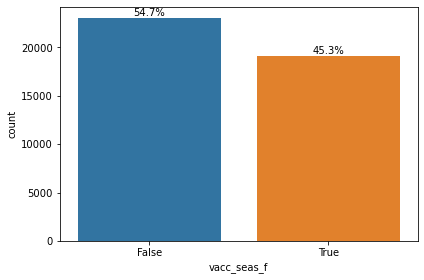

In [12]:
ax=sns.countplot(x='vacc_seas_f',data=df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / len(df):.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

##### h1n1_concern
Level of concern about the H1N1 flu.   
0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.    
Quantitive Discrete Ordinal Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : x  
Remarks : x

In [13]:
print(df['h1n1_concern'].unique())
df['h1n1_concern'].describe()

[nan  3.  2.  1.  0.]


count    33734.000000
mean         1.617004
std          0.910609
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: h1n1_concern, dtype: float64

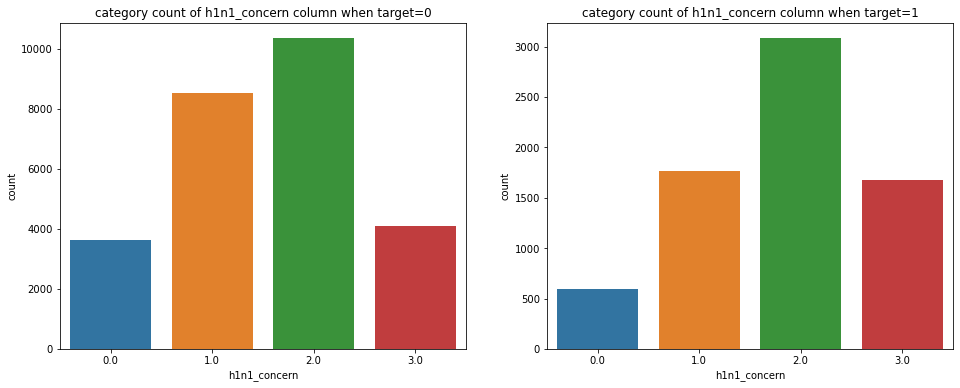

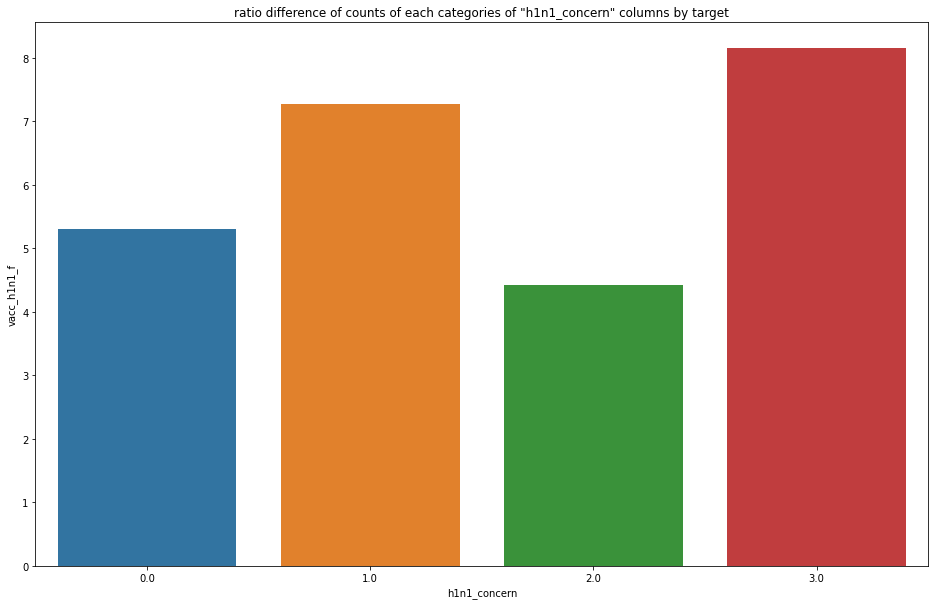

In [14]:
rdplot(df,'h1n1_concern')

##### h1n1_knowledge
Level of knowledge about H1N1 flu.   
0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.   
Quantitive Discrete Ordinal Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : x   
Remarks : x

In [15]:
print(df['h1n1_knowledge'].unique())
df['h1n1_knowledge'].describe()

[nan  1.  2.  0.]


count    33734.000000
mean         1.260272
std          0.619327
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: h1n1_knowledge, dtype: float64

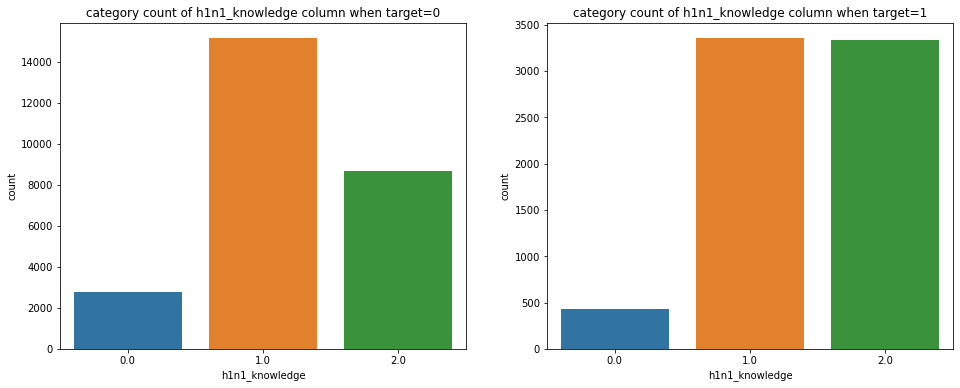

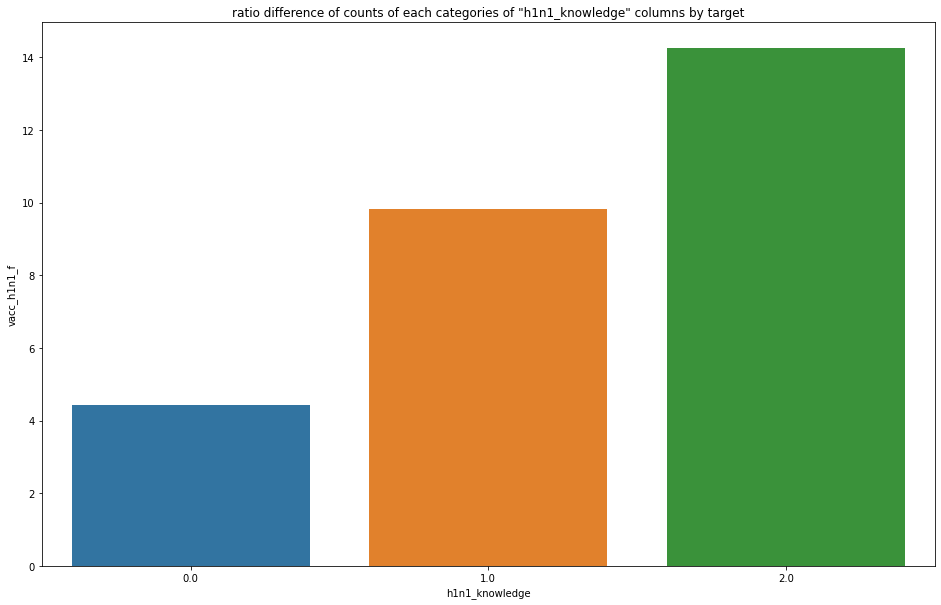

In [16]:
rdplot(df,'h1n1_knowledge')

##### behavioral_antiviral_meds
Has taken antiviral medications. (binary)   
Qualitative Discrete Binary Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : bool   
Remarks : x

In [17]:
df['behavioral_antiviral_meds']=df['behavioral_antiviral_meds'].replace(1,True).replace(0,False)
print(df['behavioral_antiviral_meds'].unique())
df['behavioral_antiviral_meds'].describe()

[nan False True]


count     33635
unique        2
top       False
freq      31930
Name: behavioral_antiviral_meds, dtype: object

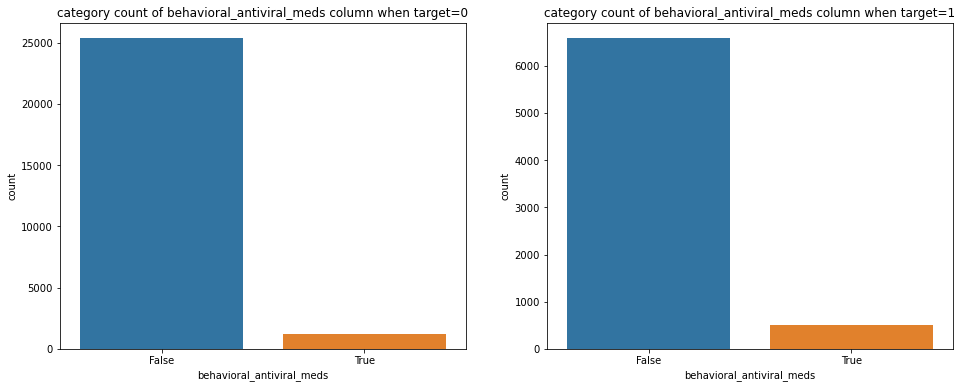

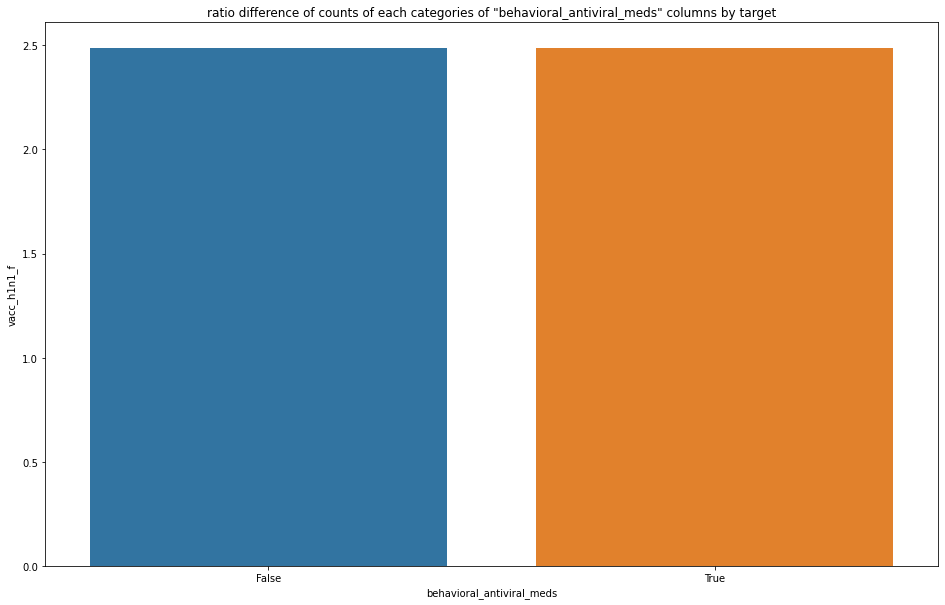

In [18]:
rdplot(df,'behavioral_antiviral_meds')

##### behavioral_avoidance
Has avoided close contact with others with flu-like symptoms. (binary)   
Qualitative Discrete Binary Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : bool   
Remarks : x

In [19]:
df['behavioral_avoidance']=df['behavioral_avoidance'].replace(1,True).replace(0,False)
print(df['behavioral_avoidance'].unique())
df['behavioral_avoidance'].describe()

[nan False True]


count     33482
unique        2
top        True
freq      24369
Name: behavioral_avoidance, dtype: object

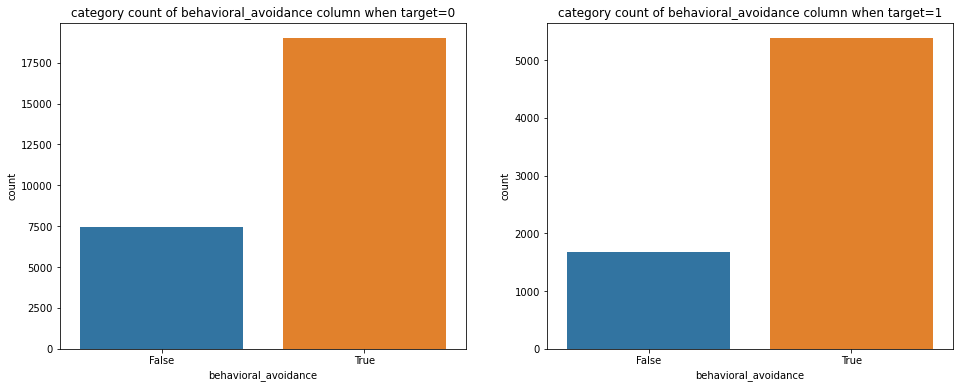

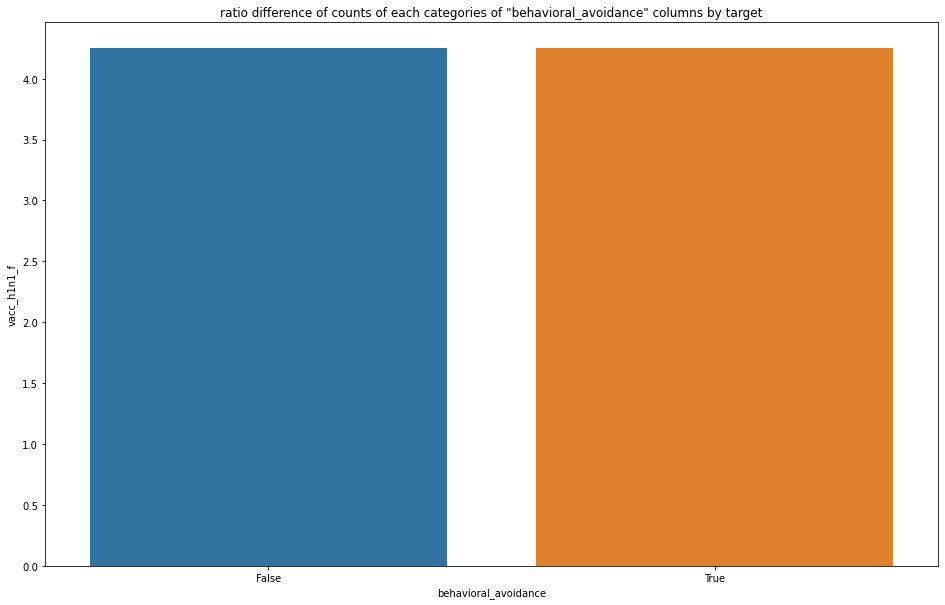

In [20]:
rdplot(df,'behavioral_avoidance')

##### behavioral_face_mask
Has bought a face mask. (binary)   
Qualitative Discrete Binary Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : bool   
Remarks : x

In [21]:
df['behavioral_face_mask']=df['behavioral_face_mask'].replace(1,True).replace(0,False)
print(df['behavioral_face_mask'].unique())
df['behavioral_face_mask'].describe()

[nan False True]


count     33710
unique        2
top       False
freq      31425
Name: behavioral_face_mask, dtype: object

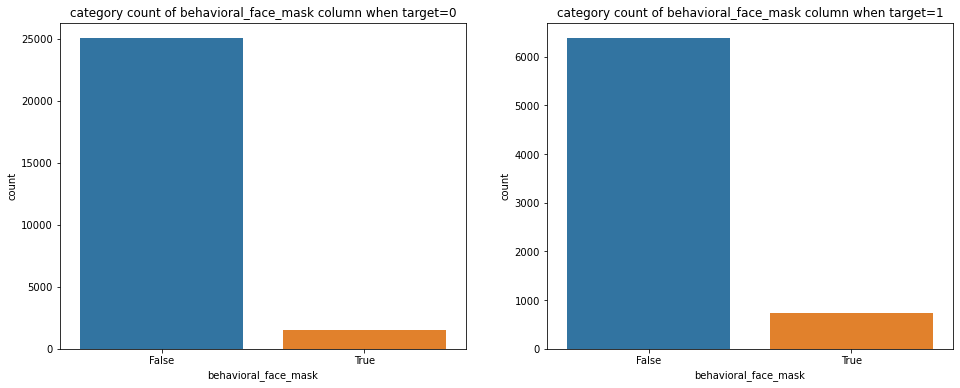

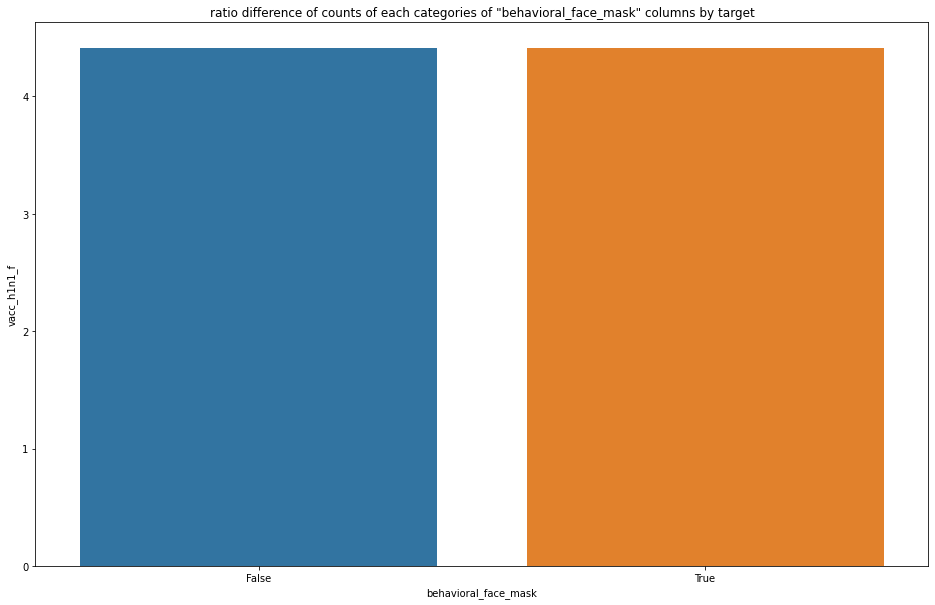

In [22]:
rdplot(df,'behavioral_face_mask')

##### behavioral_wash_hands
Has frequently washed hands or used hand sanitizer. (binary)   
Qualitative Discrete Binary Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : bool   
Remarks : x

In [23]:
df['behavioral_wash_hands']=df['behavioral_wash_hands'].replace(1,True).replace(0,False)
print(df['behavioral_wash_hands'].unique())
df['behavioral_wash_hands'].describe()

[nan True False]


count     33683
unique        2
top        True
freq      27766
Name: behavioral_wash_hands, dtype: object

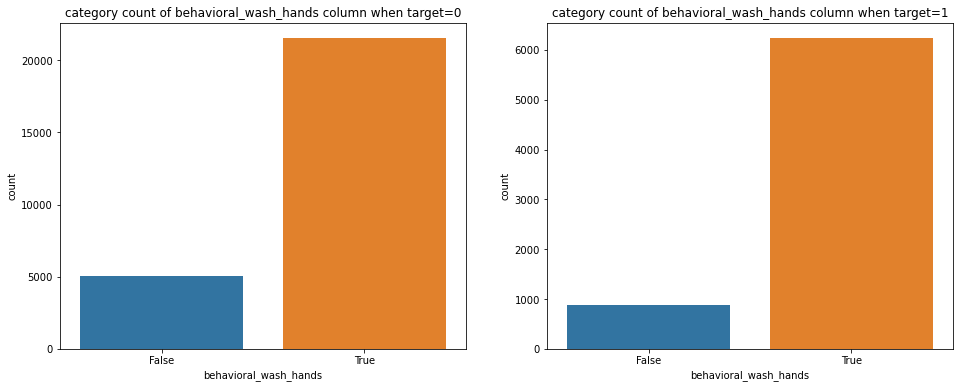

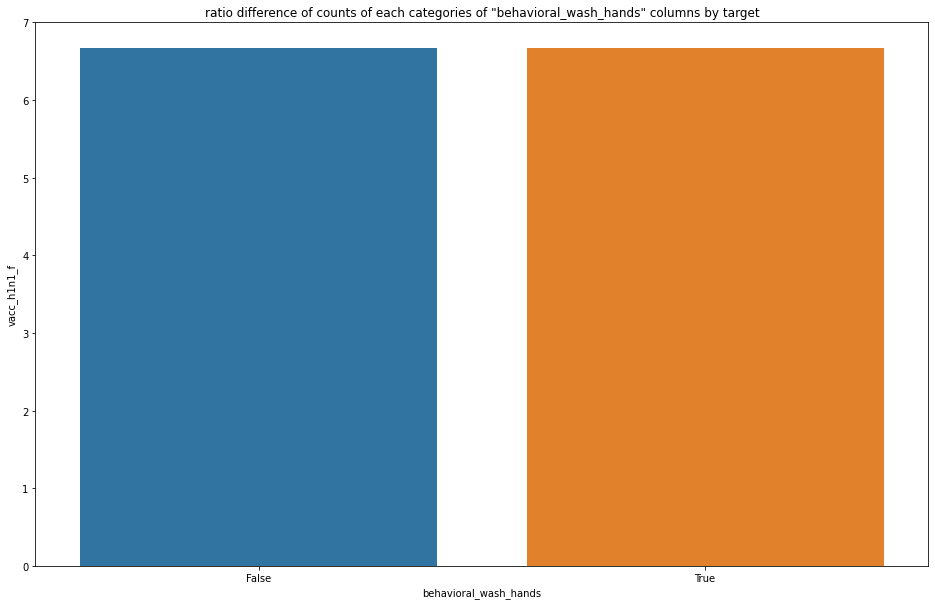

In [24]:
rdplot(df,'behavioral_wash_hands')

##### behavioral_large_gatherings
Has reduced time at large gatherings. (binary)   
Qualitative Discrete Binary Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : bool   
Remarks : x

In [25]:
df['behavioral_large_gatherings']=df['behavioral_large_gatherings'].replace(1,True).replace(0,False)
print(df['behavioral_large_gatherings'].unique())
df['behavioral_large_gatherings'].describe()

[nan False True]


count     33640
unique        2
top       False
freq      21677
Name: behavioral_large_gatherings, dtype: object

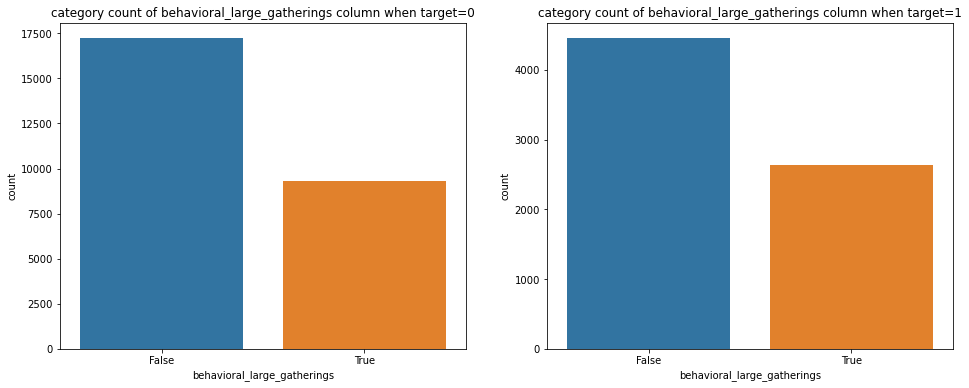

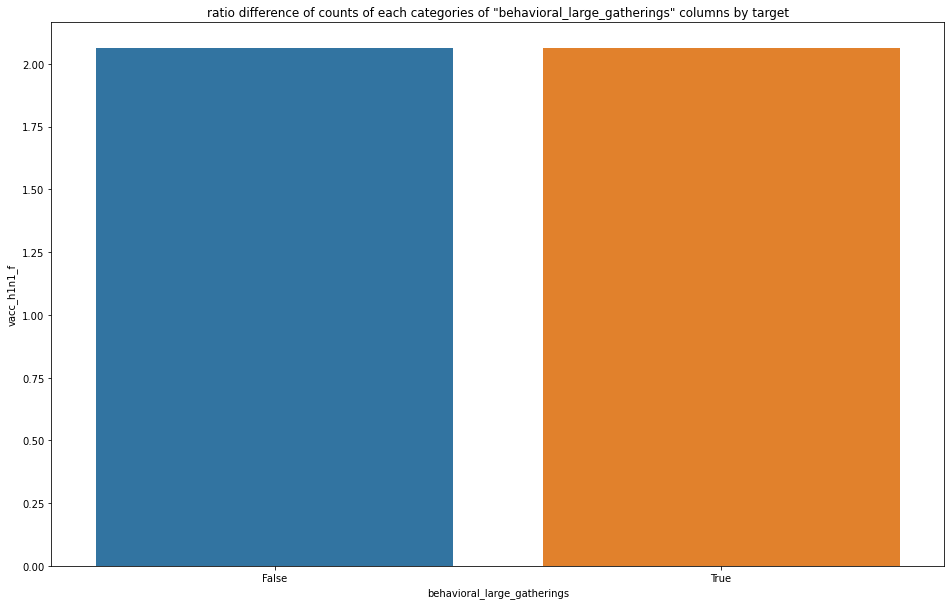

In [26]:
rdplot(df,'behavioral_large_gatherings')

##### behavioral_outside_home
Has reduced contact with people outside of own household. (binary)   
Qualitative Discrete Binary Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : bool   
Remarks : x

In [27]:
df['behavioral_outside_home']=df['behavioral_outside_home'].replace(1,True).replace(0,False)
print(df['behavioral_outside_home'].unique())
df['behavioral_outside_home'].describe()

[nan False True]


count     33633
unique        2
top       False
freq      22257
Name: behavioral_outside_home, dtype: object

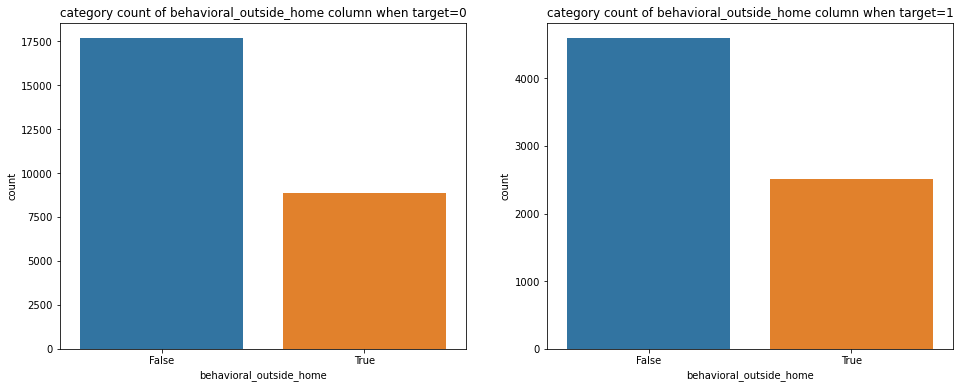

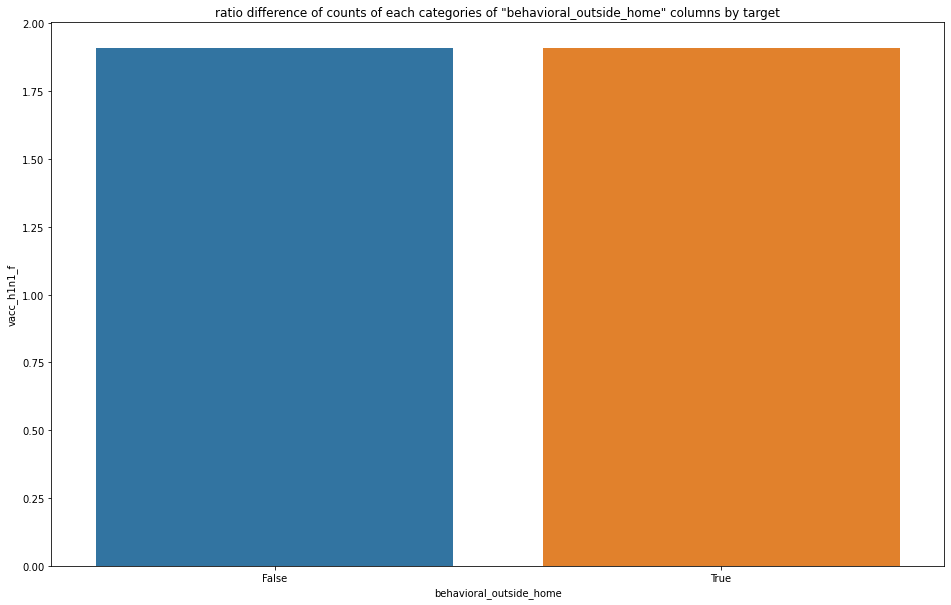

In [28]:
rdplot(df,'behavioral_outside_home')

##### behavioral_touch_face
Has avoided touching eyes, nose, or mouth. (binary)   
Qualitative Discrete Binary Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : bool   
Remarks : x

In [29]:
df['behavioral_touch_face']=df['behavioral_touch_face'].replace(1,True).replace(0,False)
print(df['behavioral_touch_face'].unique())
df['behavioral_touch_face'].describe()

[nan True False]


count     33571
unique        2
top        True
freq      22787
Name: behavioral_touch_face, dtype: object

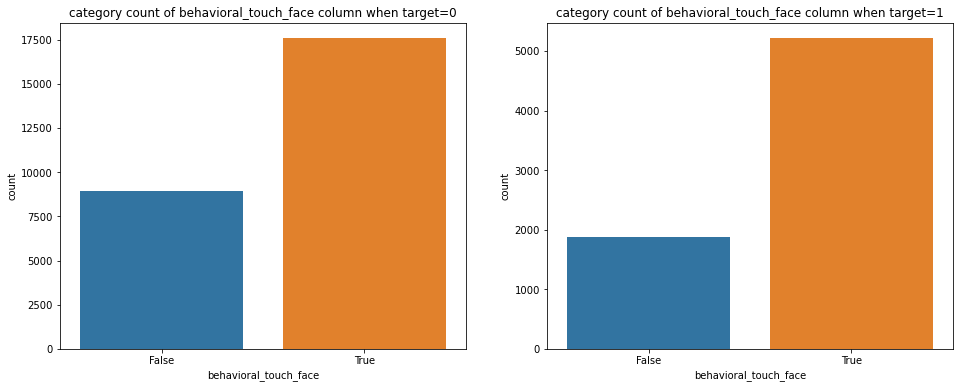

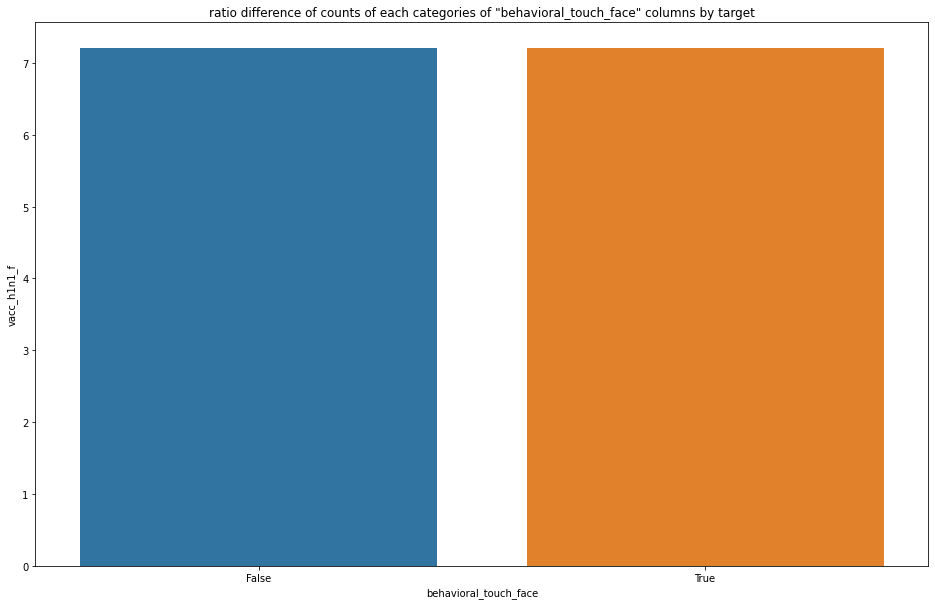

In [30]:
rdplot(df,'behavioral_touch_face')

##### doctor_recc_h1n1
H1N1 flu vaccine was recommended by doctor. (binary)   
Qualitative Discrete Binary Variable
Ordinal Encoding : x   
Binning : x   
Reformat : bool   
Remarks : x

In [31]:
df['doctor_recc_h1n1']=df['doctor_recc_h1n1'].replace(1,True).replace(0,False)
print(df['doctor_recc_h1n1'].unique())
df['doctor_recc_h1n1'].describe()

[False nan True]


count     40269
unique        2
top       False
freq      30535
Name: doctor_recc_h1n1, dtype: object

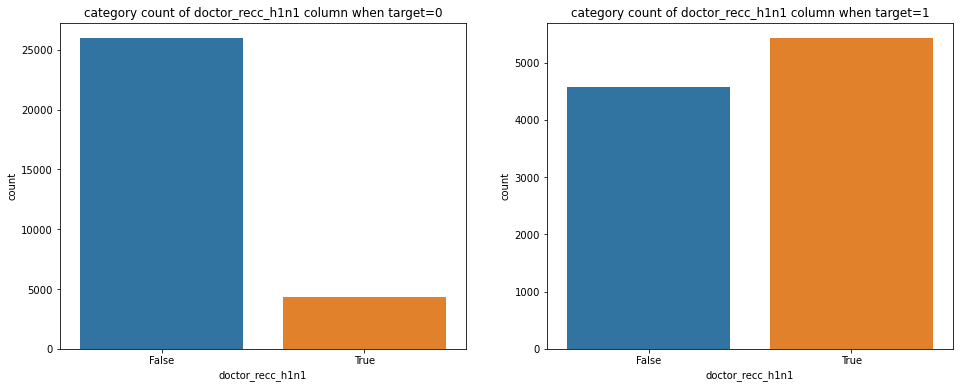

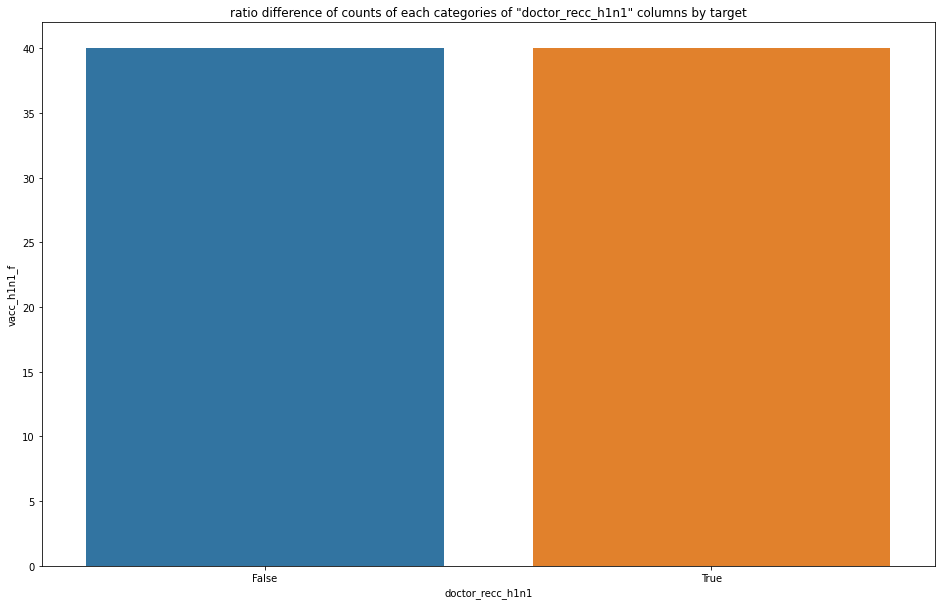

In [32]:
rdplot(df,'doctor_recc_h1n1')

##### doctor_recc_seasonal
Seasonal flu vaccine was recommended by doctor. (binary)   
Qualitative Discrete Binary Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : bool   
Remarks : x

In [33]:
df['doctor_recc_seasonal']=df['doctor_recc_seasonal'].replace(1,True).replace(0,False)
print(df['doctor_recc_seasonal'].unique())
df['doctor_recc_seasonal'].describe()

[False True nan]


count     40269
unique        2
top       False
freq      26842
Name: doctor_recc_seasonal, dtype: object

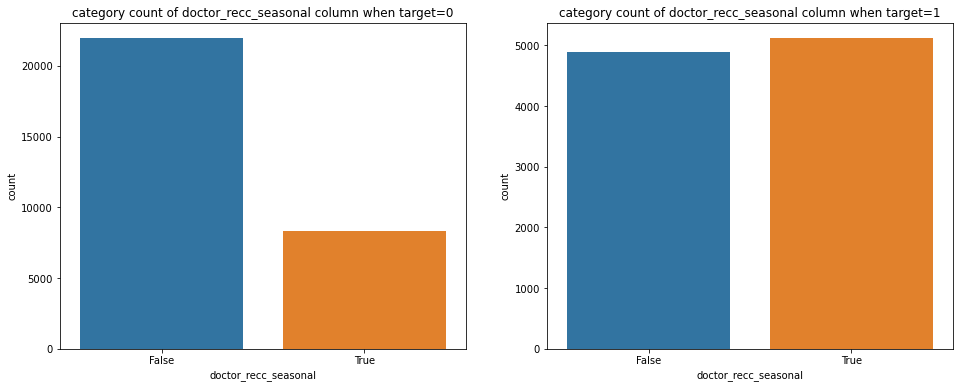

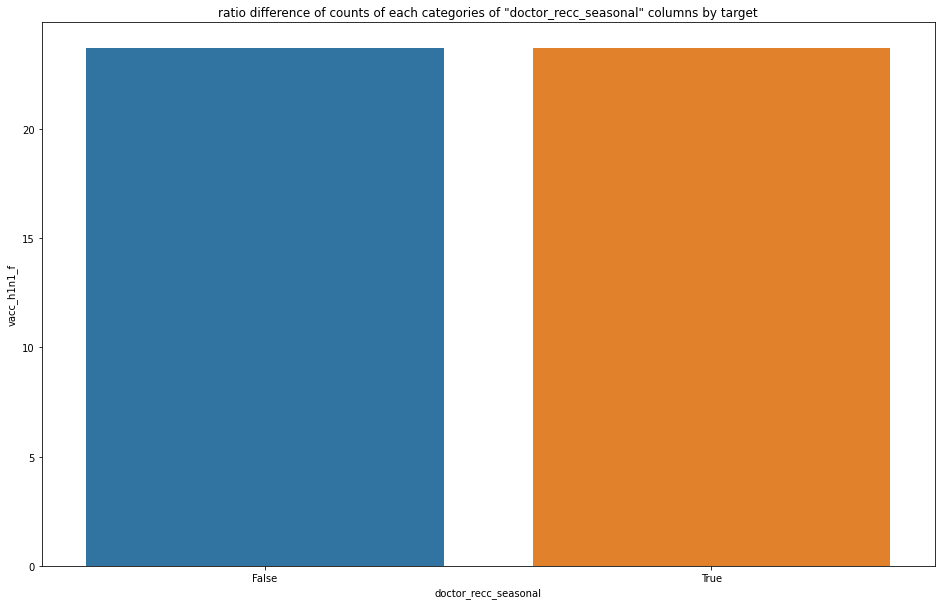

In [34]:
rdplot(df,'doctor_recc_seasonal')

##### chronic_med_condition
Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. (binary)   
Qualitative Discrete Binary Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : bool   
Remarks : x

In [35]:
df['chronic_med_condition']=df['chronic_med_condition'].replace(1,True).replace(0,False)
print(df['chronic_med_condition'].unique())
df['chronic_med_condition'].describe()

[False True nan]


count     40837
unique        2
top       False
freq      30642
Name: chronic_med_condition, dtype: object

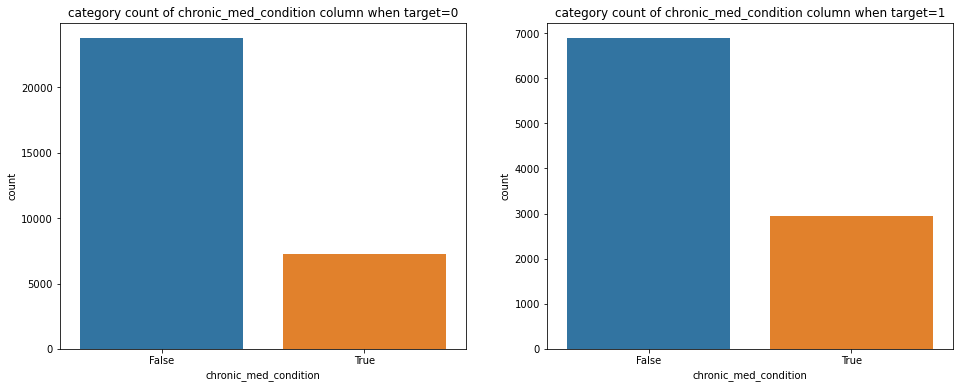

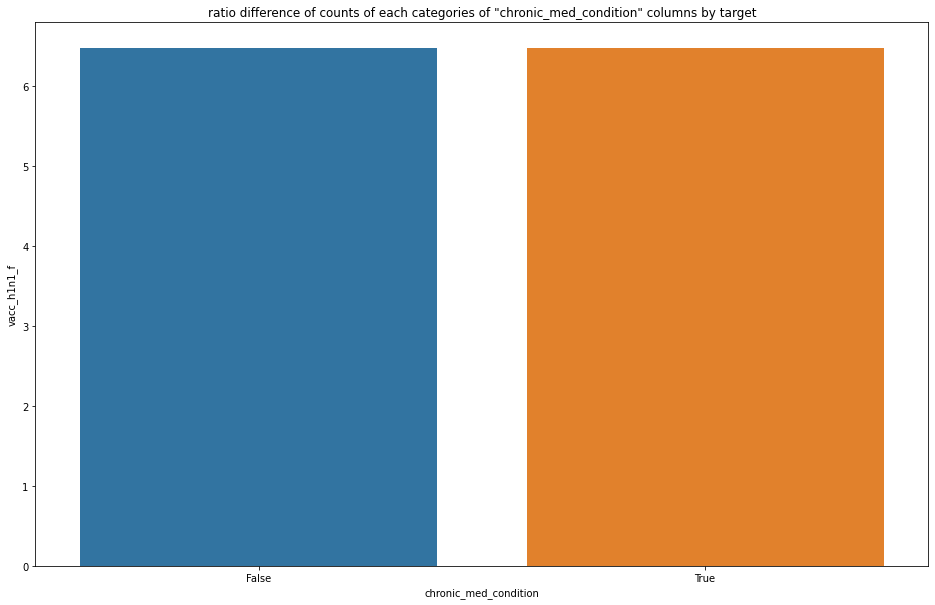

In [36]:
rdplot(df,'chronic_med_condition')

##### child_under_6_months
Has regular close contact with a child under the age of six months. (binary)   
Qualitative Discrete Binary Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : bool   
Remarks : x

In [37]:
df['child_under_6_months']=df['child_under_6_months'].replace(1,True).replace(0,False)
print(df['child_under_6_months'].unique())
df['child_under_6_months'].describe()

[nan False True]


count     32705
unique        2
top       False
freq      29958
Name: child_under_6_months, dtype: object

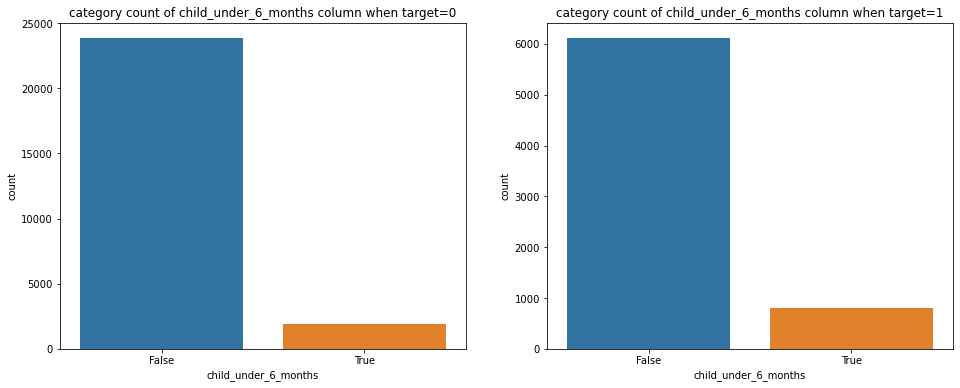

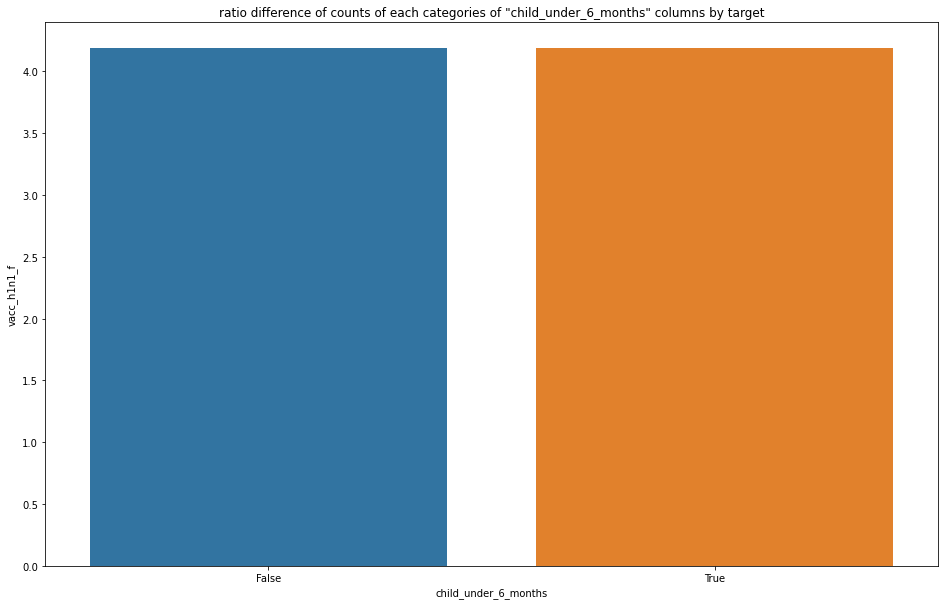

In [38]:
rdplot(df,'child_under_6_months')

##### health_insurance
Has health insurance. (binary)   
Qualitative Discrete Binary Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : bool   
Remarks : x

In [39]:
df['health_insurance']=df['health_insurance'].replace(1,True).replace(0,False)
print(df['health_insurance'].unique())
df['health_insurance'].describe()

[True nan False]


count     22733
unique        2
top        True
freq      20302
Name: health_insurance, dtype: object

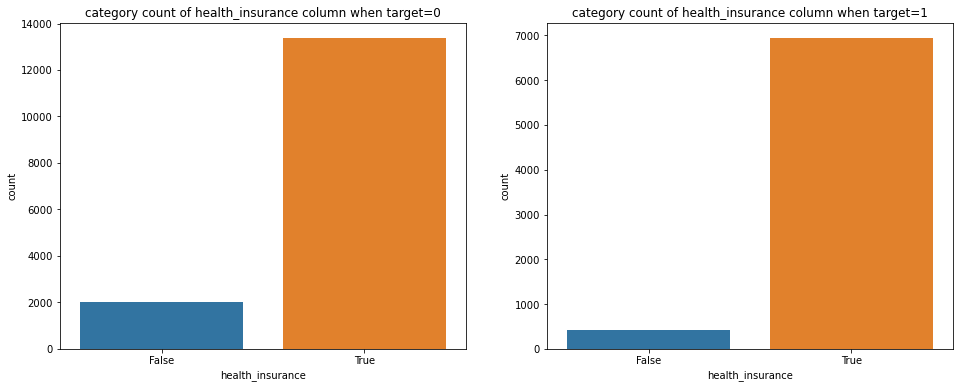

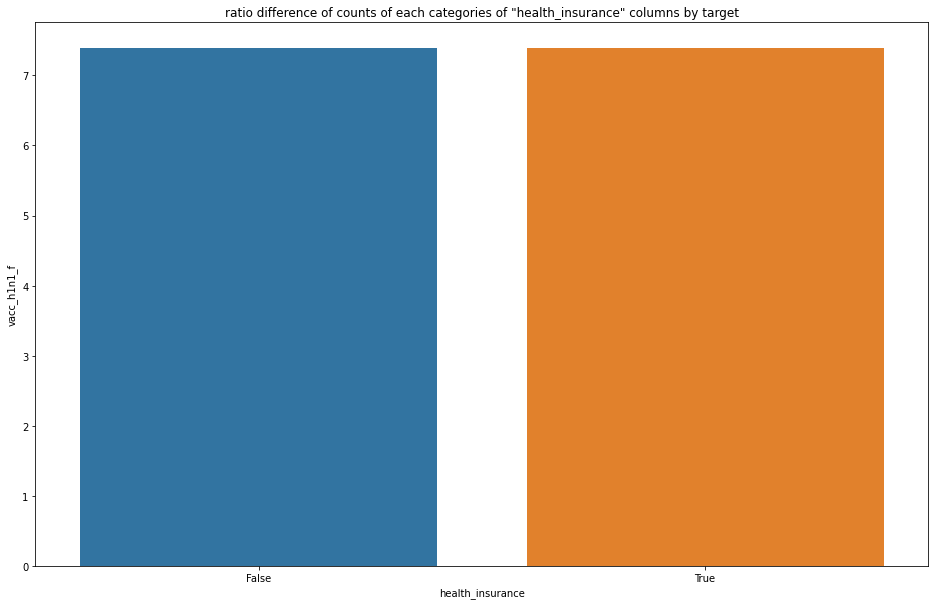

In [40]:
rdplot(df,'health_insurance')

##### health_worker
Is a healthcare worker. (binary)   
Qualitative Discrete Binary Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : bool   
Remarks : x

In [41]:
df['health_worker']=df['health_worker'].replace(1,True).replace(0,False)
print(df['health_worker'].unique())
df['health_worker'].describe()

[nan False True]


count     32724
unique        2
top       False
freq      29065
Name: health_worker, dtype: object

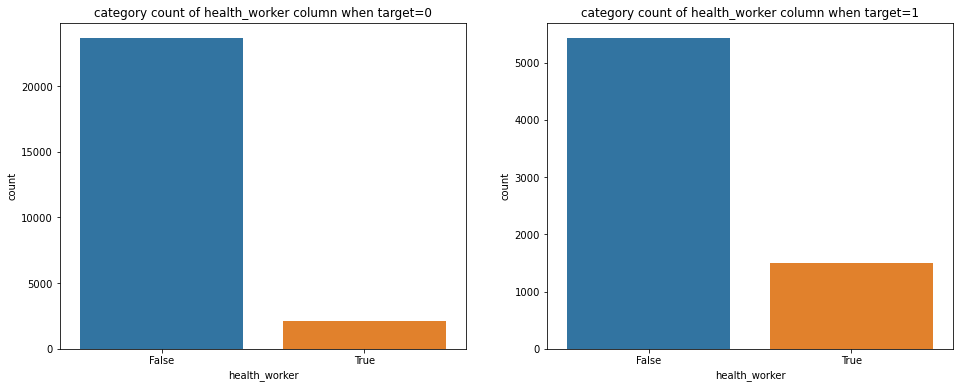

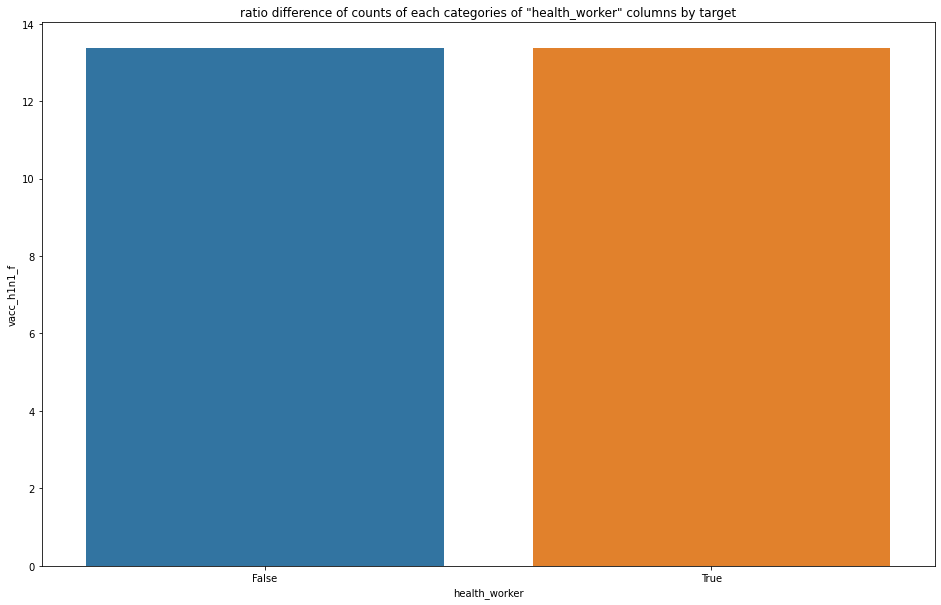

In [42]:
rdplot(df,'health_worker')

##### opinion_h1n1_vacc_effective
Respondent's opinion about H1N1 vaccine effectiveness.   
Qualitative Discrete Ordinal Variable   
Ordinal Encoding : o   
Binning : x   
Reformat : x   
Remarks : Don't Know, Refused -> nan

In [43]:
print(df['opinion_h1n1_vacc_effective'].unique())
print(df['opinion_h1n1_vacc_effective'].describe())
df['opinion_h1n1_vacc_effective'].replace('Dont Know',np.nan,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Refused',np.nan,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Not At All Effective',0,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Not Very Effective',1,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Somewhat Effective',2,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Very Effective',3,inplace=True)
print(df['opinion_h1n1_vacc_effective'].unique())
print(df['opinion_h1n1_vacc_effective'].describe())

[nan 'Very Effective' 'Somewhat Effective' 'Not Very Effective'
 'Dont Know' 'Not At All Effective' 'Refused']
count                  33375
unique                     6
top       Somewhat Effective
freq                   14729
Name: opinion_h1n1_vacc_effective, dtype: object
[nan  3.  2.  1.  0.]
count    27204.000000
mean         2.166079
std          0.743995
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          3.000000
Name: opinion_h1n1_vacc_effective, dtype: float64


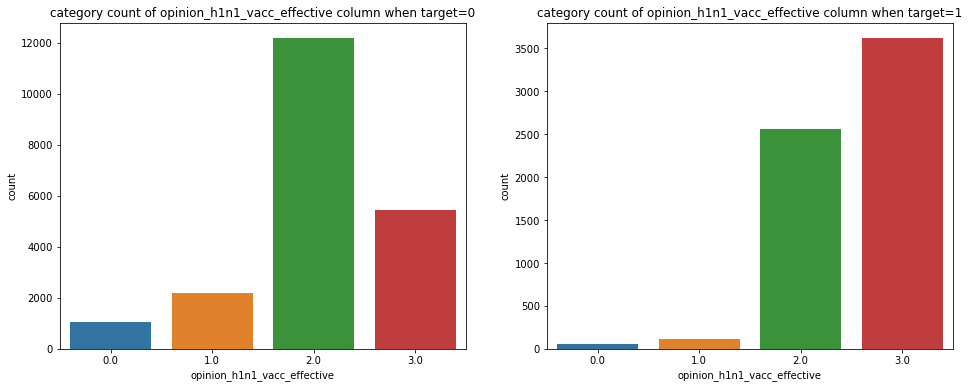

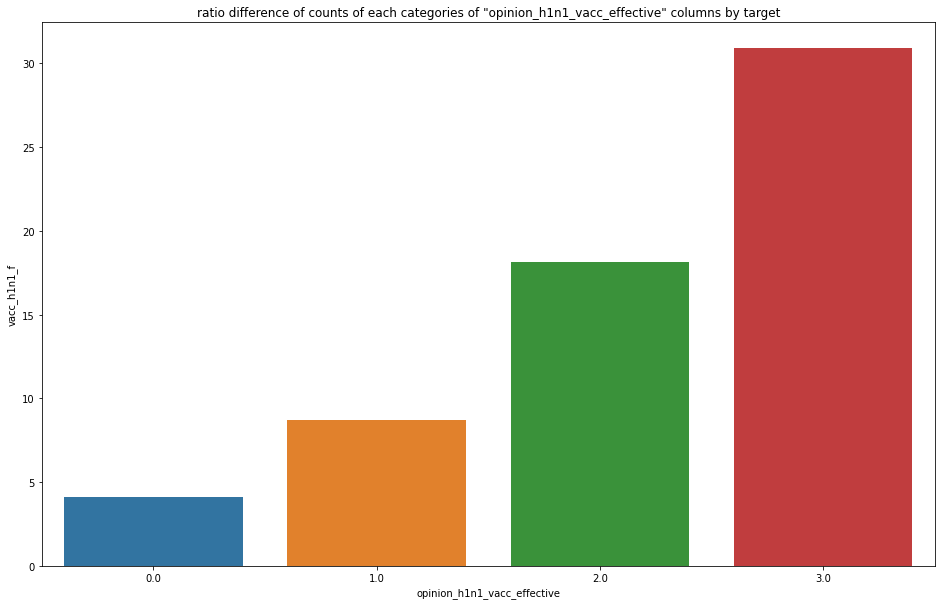

In [44]:
rdplot(df,'opinion_h1n1_vacc_effective')

##### opinion_h1n1_risk
Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.   
Qualitative Discrete Ordinal Variable   
Ordinal Encoding : o   
Binning : x   
Reformat : x   
Remarks : Don't Know, Refused -> nan

In [45]:
print(df['opinion_h1n1_risk'].unique())
print(df['opinion_h1n1_risk'].describe())
df['opinion_h1n1_risk'].replace('Dont Know',np.nan,inplace=True)
df['opinion_h1n1_risk'].replace('Refused',np.nan,inplace=True)
df['opinion_h1n1_risk'].replace('Very Low',1,inplace=True)
df['opinion_h1n1_risk'].replace('Somewhat Low',2,inplace=True)
df['opinion_h1n1_risk'].replace('Somewhat High',3,inplace=True)
df['opinion_h1n1_risk'].replace('Very High',4,inplace=True)
print(df['opinion_h1n1_risk'].unique())
print(df['opinion_h1n1_risk'].describe())

[nan 'Very Low' 'Somewhat Low' 'Refused' 'Somewhat High' 'Dont Know'
 'Very High']
count            33329
unique               6
top       Somewhat Low
freq             12520
Name: opinion_h1n1_risk, dtype: object
[nan  1.  2.  3.  4.]
count    31772.00000
mean         2.02348
std          0.89944
min          1.00000
25%          1.00000
50%          2.00000
75%          3.00000
max          4.00000
Name: opinion_h1n1_risk, dtype: float64


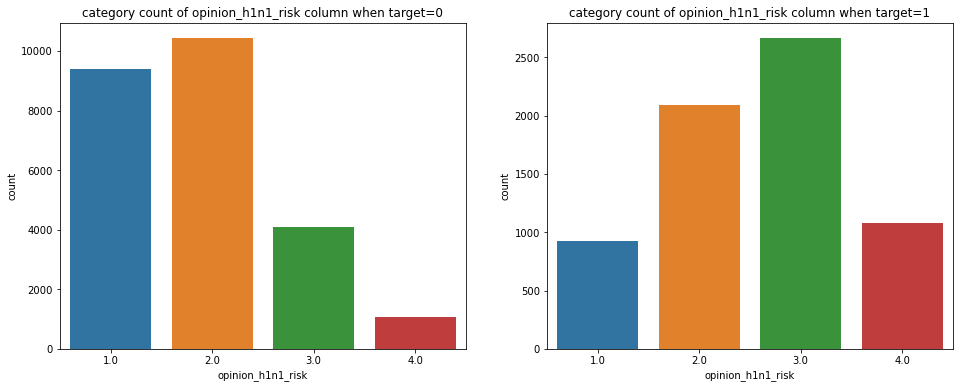

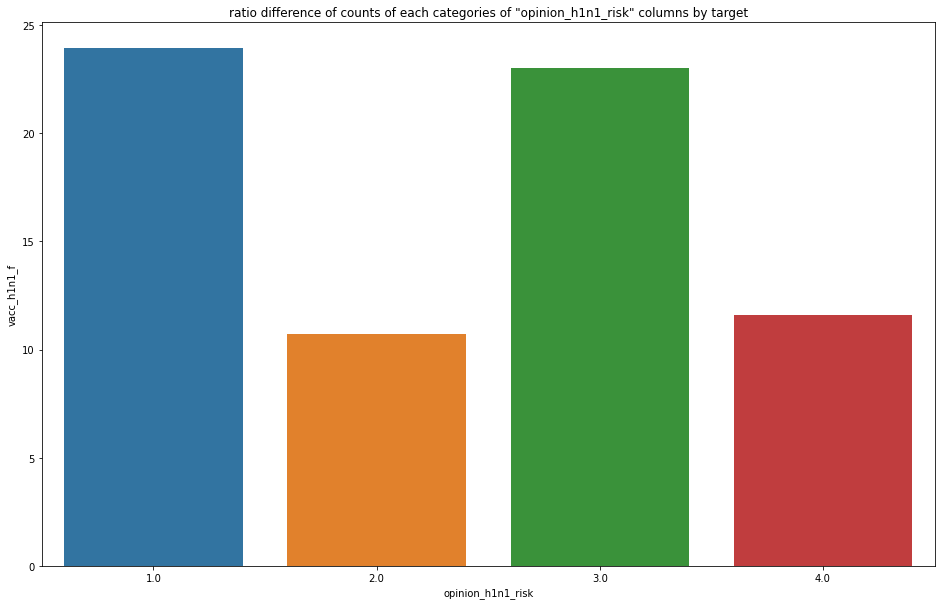

In [46]:
rdplot(df,'opinion_h1n1_risk')

##### opinion_h1n1_sick_from_vacc
Respondent's worry of getting sick from taking H1N1 vaccine.   
Qualitative Discrete Ordinal Variable   
Ordinal Encoding : o   
Binning : x   
Reformat : x   
Remarks : Don't Know, Refused -> nan

In [47]:
print(df['opinion_h1n1_sick_from_vacc'].unique())
print(df['opinion_h1n1_sick_from_vacc'].describe())
df['opinion_h1n1_sick_from_vacc'].replace('Dont Know',np.nan,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Refused',np.nan,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Not At All Worried',0,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Not Very Worried',1,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Somewhat Worried',2,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Very Worried',3,inplace=True)
print(df['opinion_h1n1_sick_from_vacc'].unique())
print(df['opinion_h1n1_sick_from_vacc'].describe())

[nan 'Not Very Worried' 'Very Worried' 'Not At All Worried'
 'Somewhat Worried' 'Dont Know' 'Refused']
count                33285
unique                   6
top       Not Very Worried
freq                 11582
Name: opinion_h1n1_sick_from_vacc, dtype: object
[nan  1.  3.  0.  2.]
count    33058.000000
mean         1.051818
std          0.946527
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          3.000000
Name: opinion_h1n1_sick_from_vacc, dtype: float64


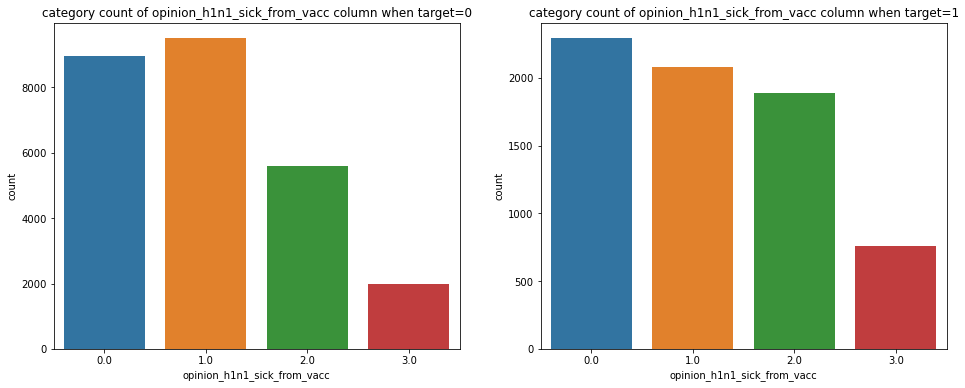

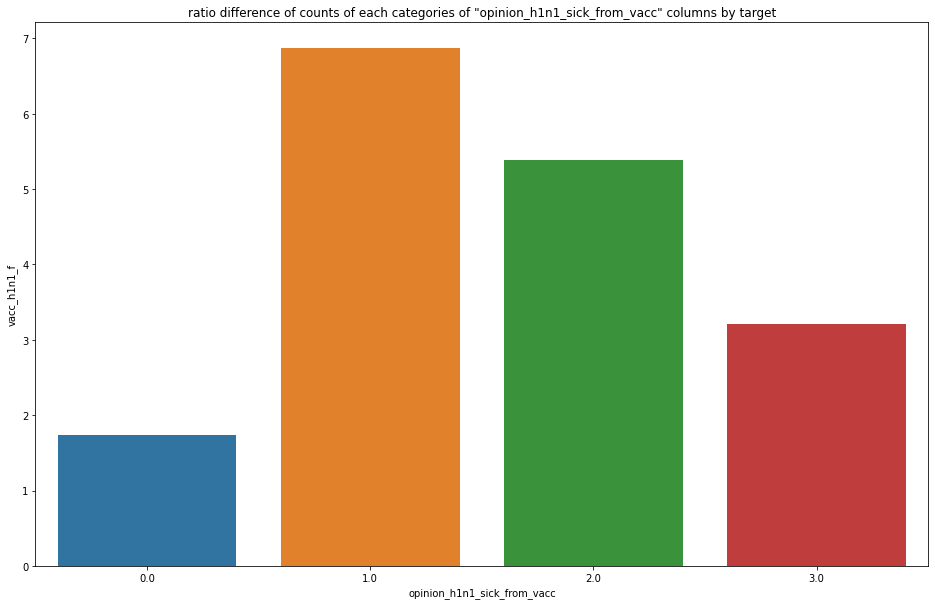

In [48]:
rdplot(df,'opinion_h1n1_sick_from_vacc')

##### opinion_seas_vacc_effective
Respondent's opinion about seasonal flu vaccine effectiveness.   
Qualitative Discrete Ordinal Variable   
Ordinal Encoding : o   
Binning : x   
Reformat : x   
Remarks : Don't Know, Refused -> nan

In [49]:
print(df['opinion_seas_vacc_effective'].unique())
print(df['opinion_seas_vacc_effective'].describe())
df['opinion_seas_vacc_effective'].replace('Dont Know',np.nan,inplace=True)
df['opinion_seas_vacc_effective'].replace('Refused',np.nan,inplace=True)
df['opinion_seas_vacc_effective'].replace('Not At All Effective',0,inplace=True)
df['opinion_seas_vacc_effective'].replace('Not Very Effective',1,inplace=True)
df['opinion_seas_vacc_effective'].replace('Somewhat Effective',2,inplace=True)
df['opinion_seas_vacc_effective'].replace('Very Effective',3,inplace=True)
print(df['opinion_seas_vacc_effective'].unique())
print(df['opinion_seas_vacc_effective'].describe())

[nan 'Very Effective' 'Somewhat Effective' 'Not At All Effective'
 'Not Very Effective' 'Dont Know' 'Refused']
count                  33220
unique                     6
top       Somewhat Effective
freq                   14543
Name: opinion_seas_vacc_effective, dtype: object
[nan  3.  2.  0.  1.]
count    31559.000000
mean         2.213568
std          0.798323
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          3.000000
Name: opinion_seas_vacc_effective, dtype: float64


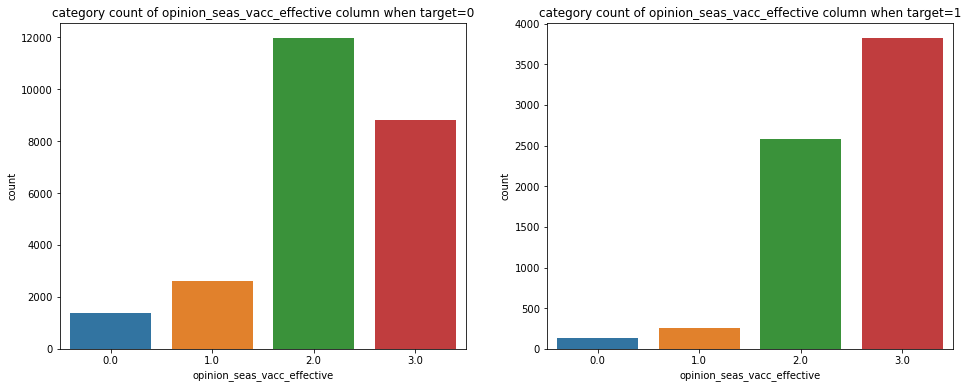

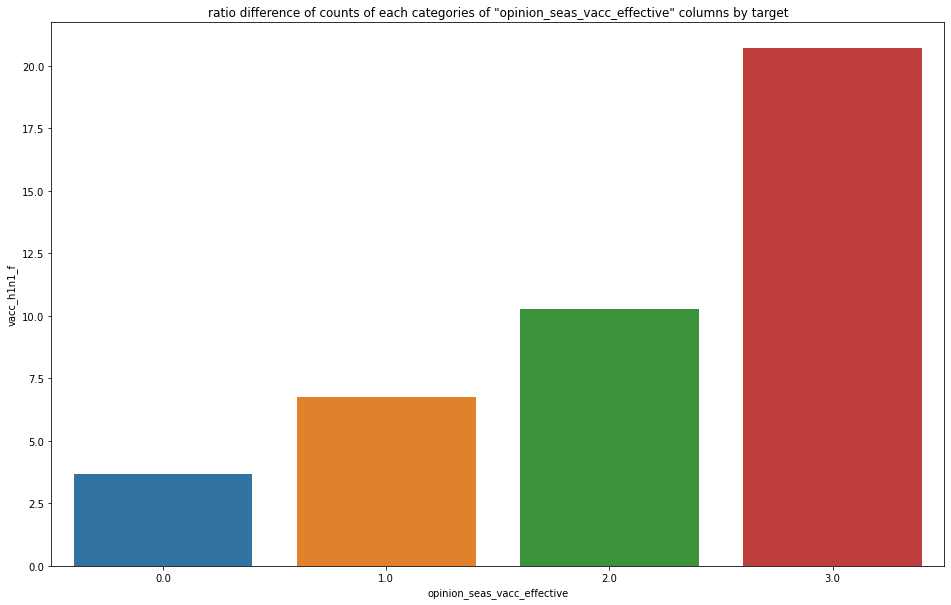

In [50]:
rdplot(df,'opinion_seas_vacc_effective')

##### opinion_seas_risk
Respondent's opinion about risk of getting sick with seasonal flu without vaccine.   
Qualitative Discrete Ordinal Variable   
Ordinal Encoding : o   
Binning : x   
Reformat : x   
Remarks : Don't Know, Refused -> nan

In [51]:
print(df['opinion_seas_risk'].unique())
print(df['opinion_seas_risk'].describe())
df['opinion_seas_risk'].replace('Dont Know',np.nan,inplace=True)
df['opinion_seas_risk'].replace('Refused',np.nan,inplace=True)
df['opinion_seas_risk'].replace('Very Low',1,inplace=True)
df['opinion_seas_risk'].replace('Somewhat Low',2,inplace=True)
df['opinion_seas_risk'].replace('Somewhat High',3,inplace=True)
df['opinion_seas_risk'].replace('Very High',4,inplace=True)
print(df['opinion_seas_risk'].unique())
print(df['opinion_seas_risk'].describe())

[nan 'Somewhat Low' 'Very High' 'Very Low' 'Somewhat High' 'Dont Know'
 'Refused']
count            33153
unique               6
top       Somewhat Low
freq             11397
Name: opinion_seas_risk, dtype: object
[nan  2.  4.  1.  3.]
count    32222.000000
mean         2.292812
std          0.951450
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: opinion_seas_risk, dtype: float64


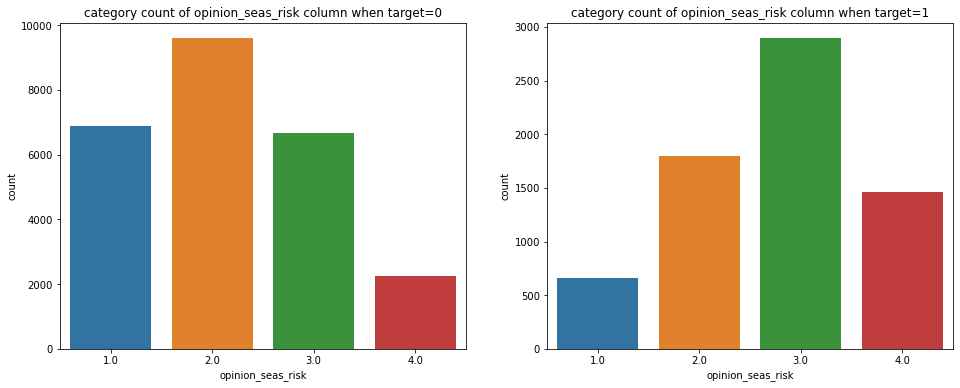

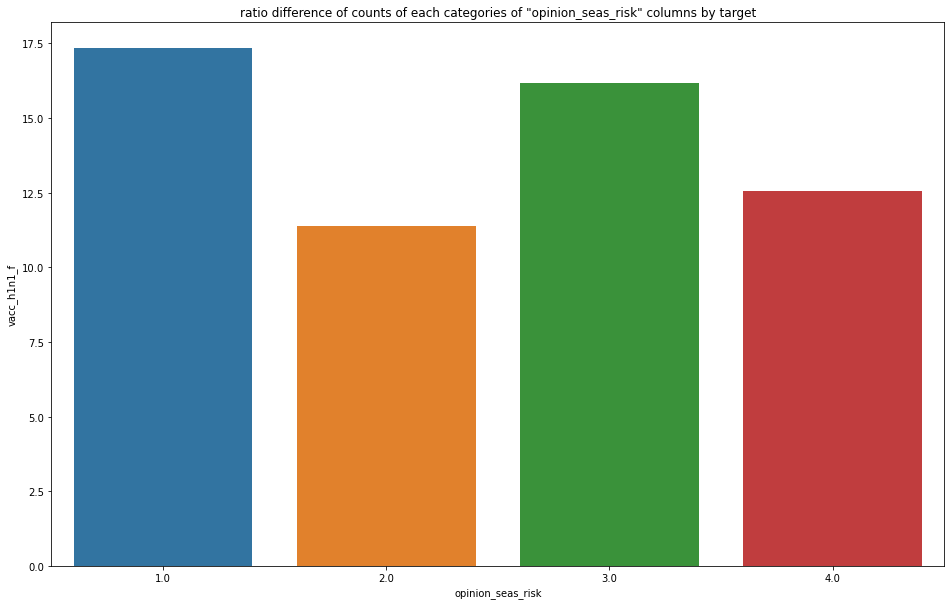

In [52]:
rdplot(df,'opinion_seas_risk')

##### opinion_seas_sick_from_vacc
Respondent's worry of getting sick from taking seasonal flu vaccine.   
Qualitative Discrete Ordinal Variable   
Ordinal Encoding : o   
Binning : x   
Reformat : x   
Remarks : Don't Know, Refused -> nan

In [53]:
print(df['opinion_seas_sick_from_vacc'].unique())
print(df['opinion_seas_sick_from_vacc'].describe())
df['opinion_seas_sick_from_vacc'].replace('Dont Know',np.nan,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Refused',np.nan,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Not At All Worried',0,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Not Very Worried',1,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Somewhat Worried',2,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Very Worried',3,inplace=True)
print(df['opinion_seas_sick_from_vacc'].unique())
print(df['opinion_seas_sick_from_vacc'].describe())

[nan 'Not At All Worried' 'Very Worried' 'Not Very Worried'
 'Somewhat Worried' 'Refused' 'Dont Know']
count                  33089
unique                     6
top       Not At All Worried
freq                   14749
Name: opinion_seas_sick_from_vacc, dtype: object
[nan  0.  3.  1.  2.]
count    32939.000000
mean         0.876469
std          0.944388
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          3.000000
Name: opinion_seas_sick_from_vacc, dtype: float64


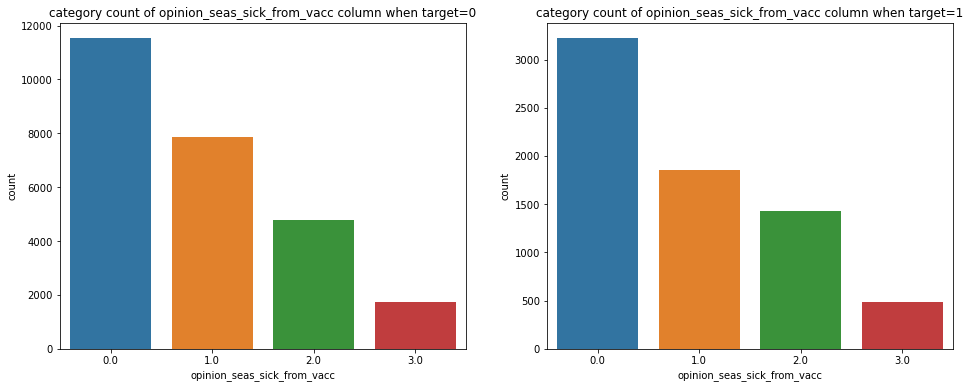

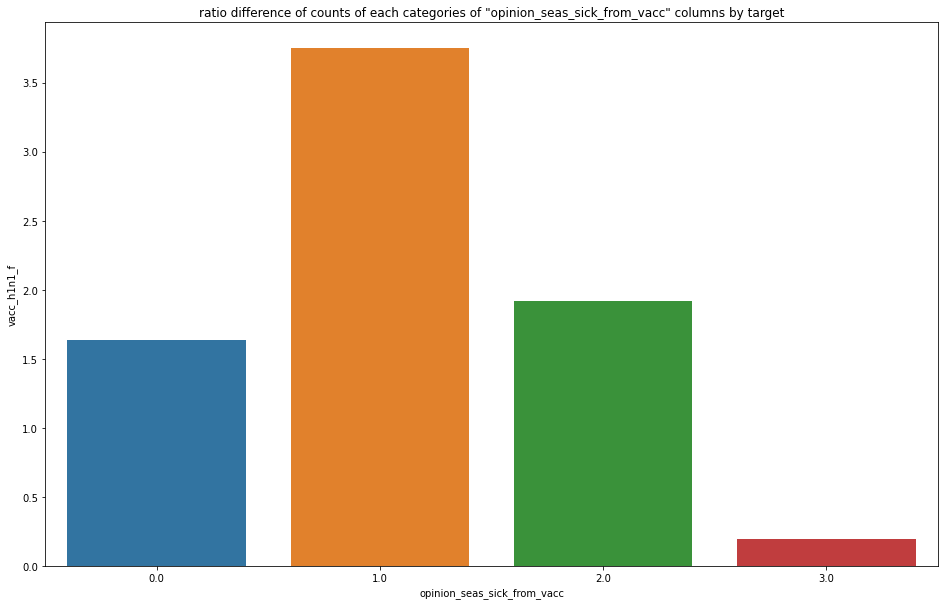

In [54]:
rdplot(df,'opinion_seas_sick_from_vacc')

##### agegrp
Age group of respondent.   
Quantative Continuous Interval Variable   
Ordinal Encoding : o   
Binning : x   
Reformat : x   
Remarks : x

In [55]:
print(df['agegrp'].unique())
print(df['agegrp'].describe())
df['agegrp'].replace('6 Months - 9 Years',1,inplace=True)
df['agegrp'].replace('10 - 17 Years',2,inplace=True)
df['agegrp'].replace('18 - 34 Years',3,inplace=True)
df['agegrp'].replace('35 - 44 Years',4,inplace=True)
df['agegrp'].replace('45 - 54 Years',5,inplace=True)
df['agegrp'].replace('55 - 64 Years',6,inplace=True)
df['agegrp'].replace('65+ Years',7,inplace=True)
print(df['agegrp'].unique())
print(df['agegrp'].describe())

['10 - 17 Years' '45 - 54 Years' '35 - 44 Years' '55 - 64 Years'
 '18 - 34 Years' '6 Months - 9 Years' '65+ Years']
count         42154
unique            7
top       65+ Years
freq           8517
Name: agegrp, dtype: object
[2 5 4 6 3 1 7]
count    42154.000000
mean         4.438369
std          1.979639
min          1.000000
25%          3.000000
50%          5.000000
75%          6.000000
max          7.000000
Name: agegrp, dtype: float64


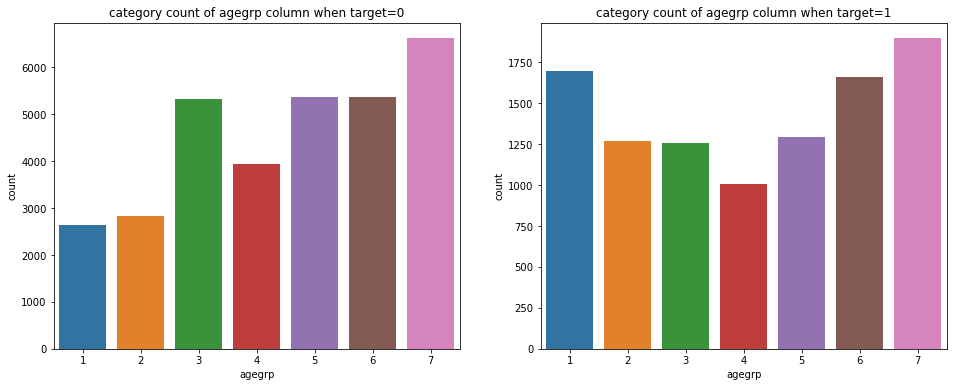

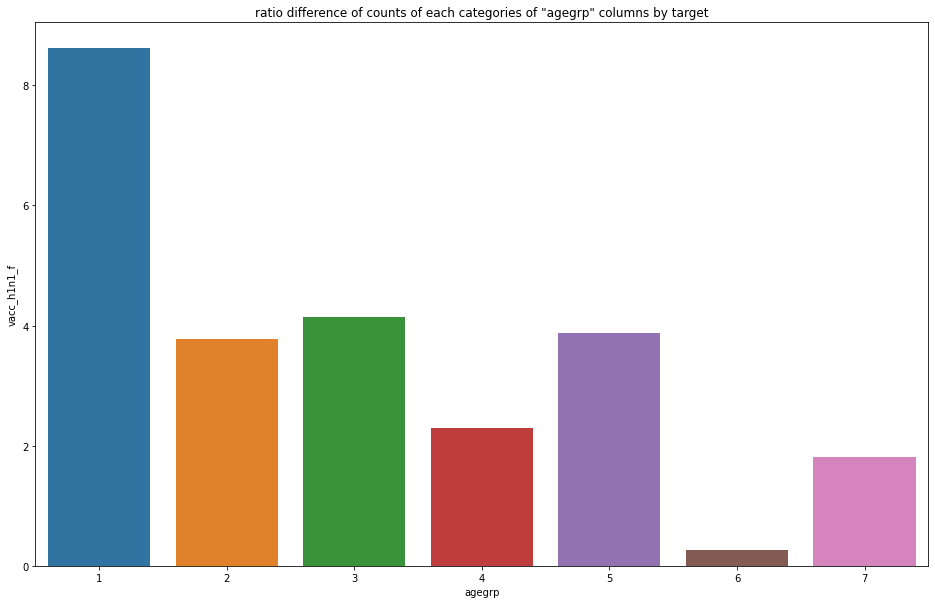

In [56]:
rdplot(df,'agegrp')

##### education_comp
Self-reported education level.   
1 = < 12 Years; 2 = 12 Years; 3 = Some College; 4 = College Graduate   
Qualitative Discrete Ordinal Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : x   
Remarks : x

In [57]:
print(df['education_comp'].unique())
df['education_comp'].describe()

[nan  3.  4.  1.  2.]


count    31988.000000
mean         2.980430
std          1.001355
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          4.000000
Name: education_comp, dtype: float64

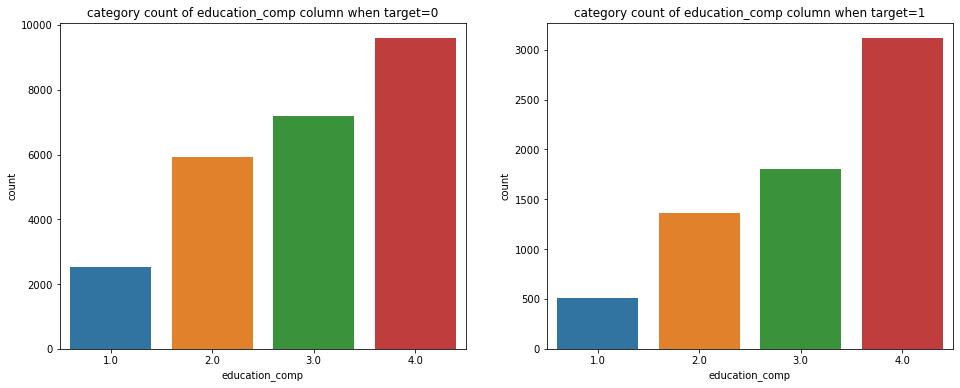

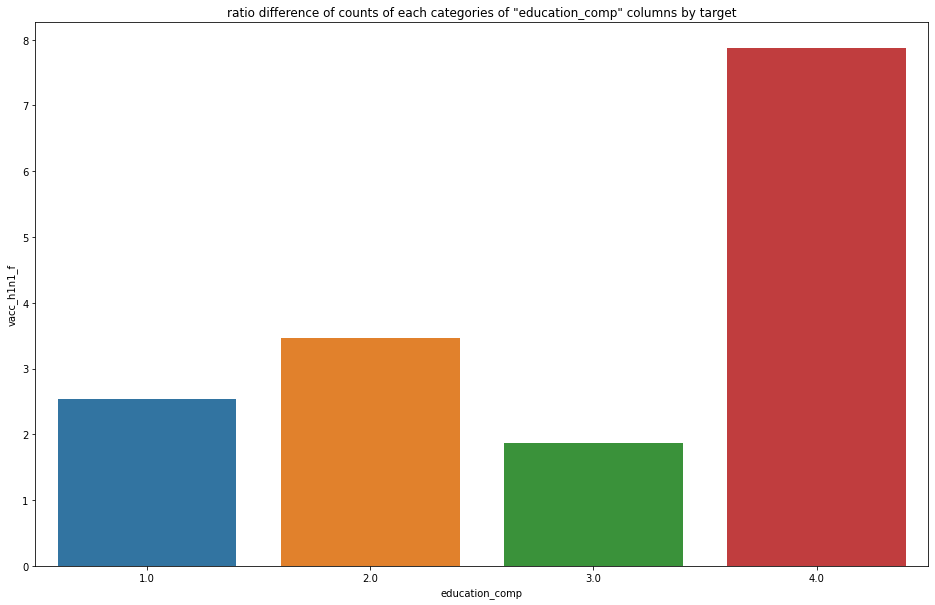

In [58]:
rdplot(df,'education_comp')

##### raceeth4_i
Race of respondent.   
1 = Hispanic; 2 = Non-Hispanic, Black Only; 3 = Non-Hispanic, White Only; 4 = Non-Hispanic, Other or Multiple Races   
Qualitative Discrete Normial Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : x   
Remarks : categorical encoding needed

In [59]:
print(df['raceeth4_i'].unique())
print(df['raceeth4_i'].describe())
df['raceeth4_i'].replace(1,'Hispanic',inplace=True)
df['raceeth4_i'].replace(2,'Non-Hispanic, Black Only',inplace=True)
df['raceeth4_i'].replace(3,'Non-Hispanic, White Only',inplace=True)
df['raceeth4_i'].replace(4,'Non-Hispanic, Other or Multiple Races ',inplace=True)
print(df['raceeth4_i'].unique())
print(df['raceeth4_i'].describe())
categorical_encoding_needed.append('raceeth4_i')

[3 1 2 4]
count    42154.000000
mean         2.830313
std          0.651123
min          1.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: raceeth4_i, dtype: float64
['Non-Hispanic, White Only' 'Hispanic' 'Non-Hispanic, Black Only'
 'Non-Hispanic, Other or Multiple Races ']
count                        42154
unique                           4
top       Non-Hispanic, White Only
freq                         32747
Name: raceeth4_i, dtype: object


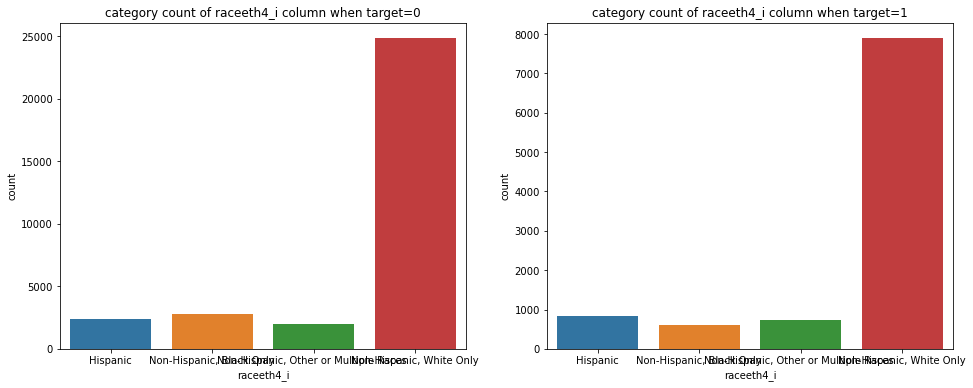

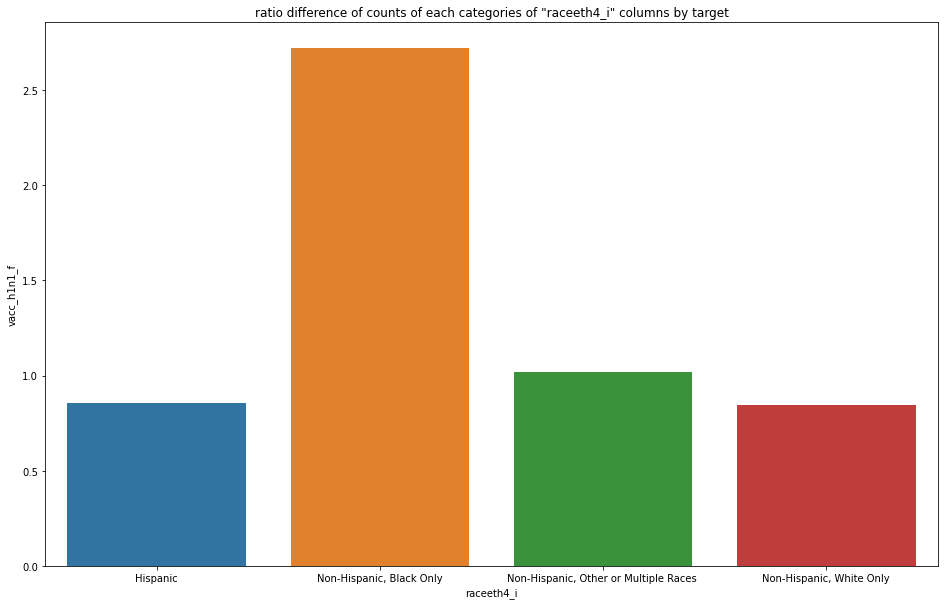

In [60]:
rdplot(df,'raceeth4_i')

##### sex_i
Sex of respondent.   
1 = Male; 2 = Female   
Qualitative Discrete Binary Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : bool   
Remarks : Male=True, Female=False

In [61]:
print(df['sex_i'].unique())
print(df['sex_i'].describe())
df['sex_i'].replace(1,'True',inplace=True)
df['sex_i'].replace(2,'False',inplace=True)
print(df['sex_i'].unique())
print(df['sex_i'].describe())

[1 2]
count    42154.000000
mean         1.571832
std          0.494819
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: sex_i, dtype: float64
['True' 'False']
count     42154
unique        2
top       False
freq      24105
Name: sex_i, dtype: object


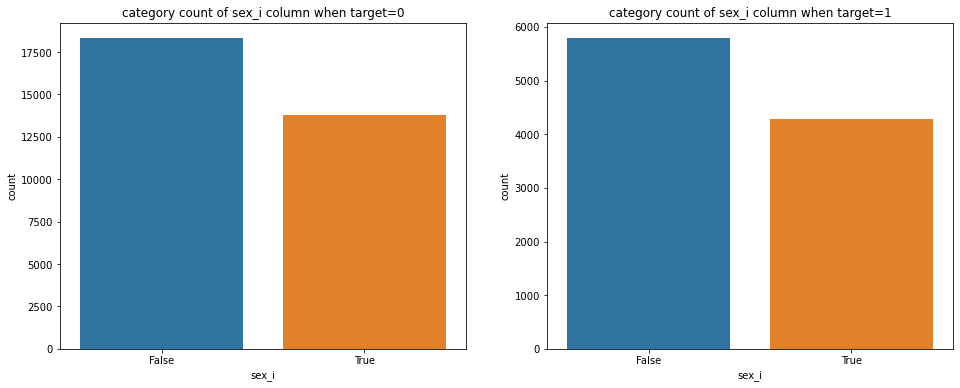

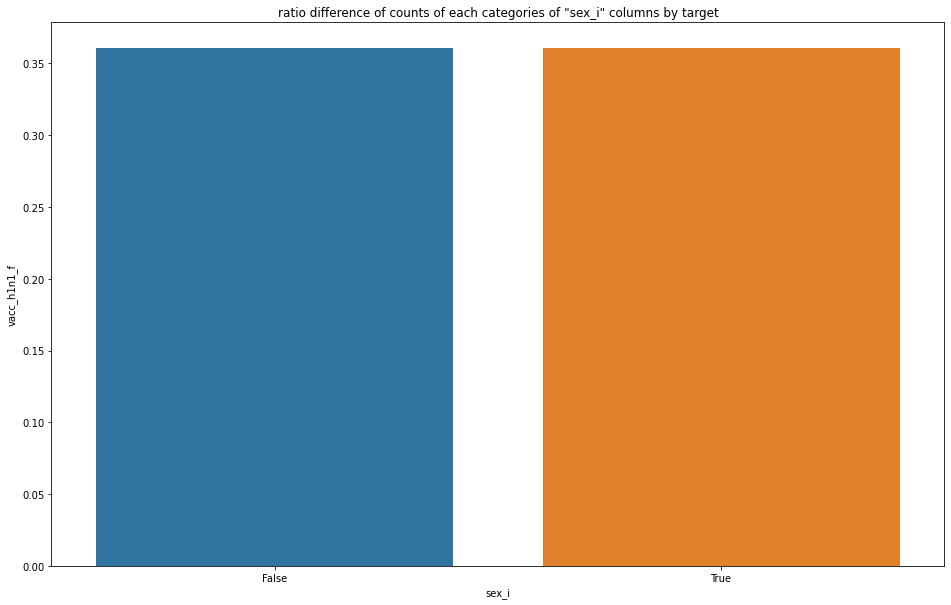

In [62]:
rdplot(df,'sex_i')

##### inc_pov
Household annual income of respondent with respect to 2008 Census poverty thresholds.   
1 = > $75,000; 2 = <= $75,000; 3 = Below Poverty; 4 = Unknown   
Qualitative Discrete Ordinal Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : x   
Remarks : 4(Unknown) -> np.nan, 3(Below Poverty) -> 1, 1(>=$7500) -> 3

In [63]:
print(df['inc_pov'].unique())
print(df['inc_pov'].describe())
df['inc_pov'].replace(4,np.nan,inplace=True)
df['inc_pov'].replace(3,5,inplace=True)
df['inc_pov'].replace(1,3,inplace=True)
df['inc_pov'].replace(5,1,inplace=True)
print(df['inc_pov'].unique())
print(df['inc_pov'].describe())

[2 1 3 4]
count    42154.000000
mean         2.132728
std          0.991463
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: inc_pov, dtype: float64
[ 2.  3.  1. nan]
count    35641.000000
mean         2.208496
std          0.639551
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          3.000000
Name: inc_pov, dtype: float64


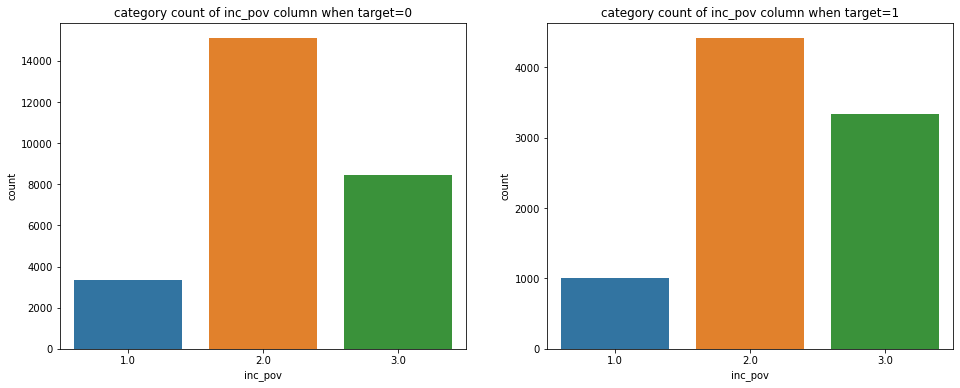

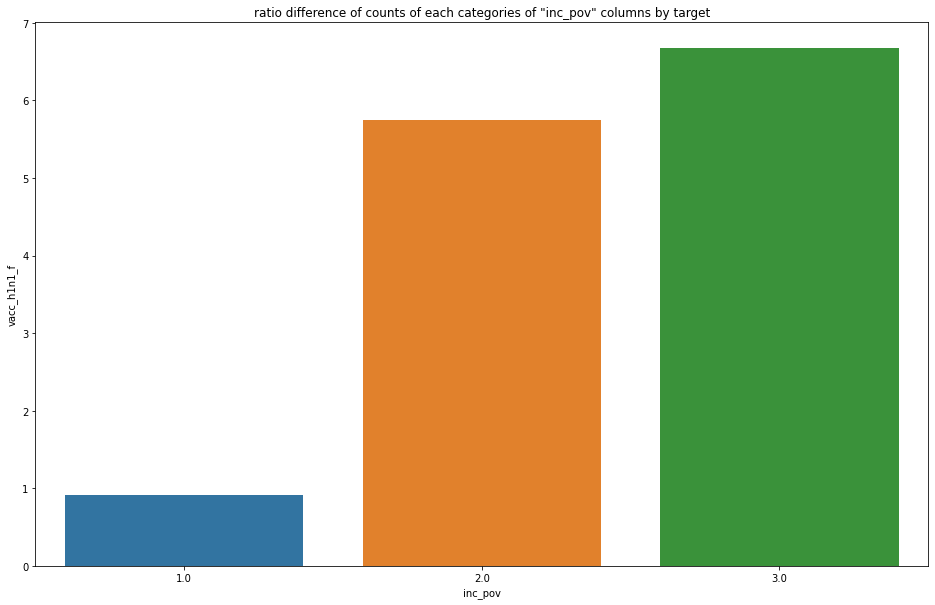

In [64]:
rdplot(df,'inc_pov')

##### marital
Marital status of respondent.   
1 = Married; 2 = Not Married   
Qualitative Discrete Binary Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : bool   
Remarks : x

In [65]:
print(df['marital'].unique())
print(df['marital'].describe())
df['marital'].replace(1,True,inplace=True)
df['marital'].replace(2,False,inplace=True)
print(df['marital'].unique())
print(df['marital'].describe())

[nan  2.  1.]
count    31955.000000
mean         1.464059
std          0.498714
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: marital, dtype: float64
[nan False True]
count     31955
unique        2
top        True
freq      17126
Name: marital, dtype: object


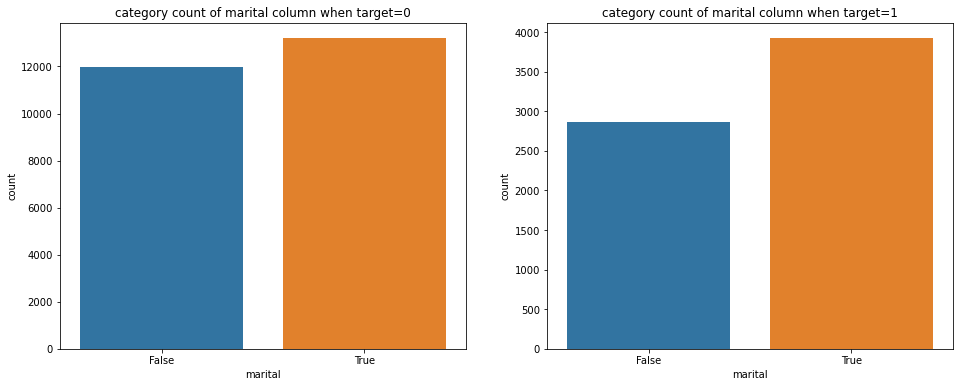

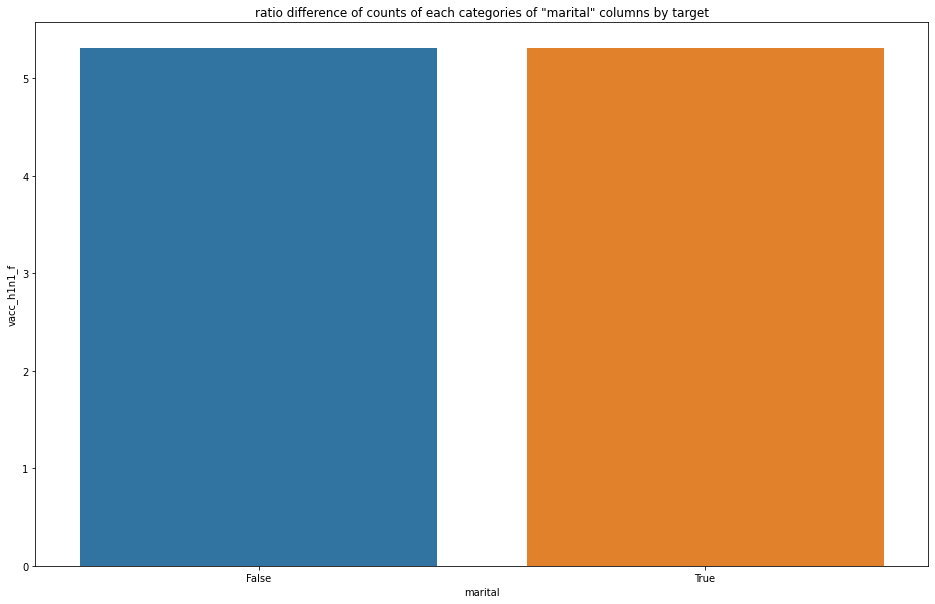

In [66]:
rdplot(df,'marital')

##### rent_own_r
Housing situation of respondent.   
1 = Home is Owned; 2 = Home is Rented or Other Arrangement   
Qualitative Discrete Binary Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : bool   
Remarks : Outliers(77,99 -> np.nan)

In [67]:
print(df['rent_own_r'].unique())
print(df['rent_own_r'].describe())
df['rent_own_r'].replace(77,np.nan,inplace=True)
df['rent_own_r'].replace(99,np.nan,inplace=True)
df['rent_own_r'].replace(1,True,inplace=True)
df['rent_own_r'].replace(2,False,inplace=True)
print(df['rent_own_r'].unique())
print(df['rent_own_r'].describe())

[ 2.  1. nan 77. 99.]
count    39958.000000
mean         2.915261
std         12.597018
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         99.000000
Name: rent_own_r, dtype: float64
[False True nan]
count     39258
unique        2
top        True
freq      29920
Name: rent_own_r, dtype: object


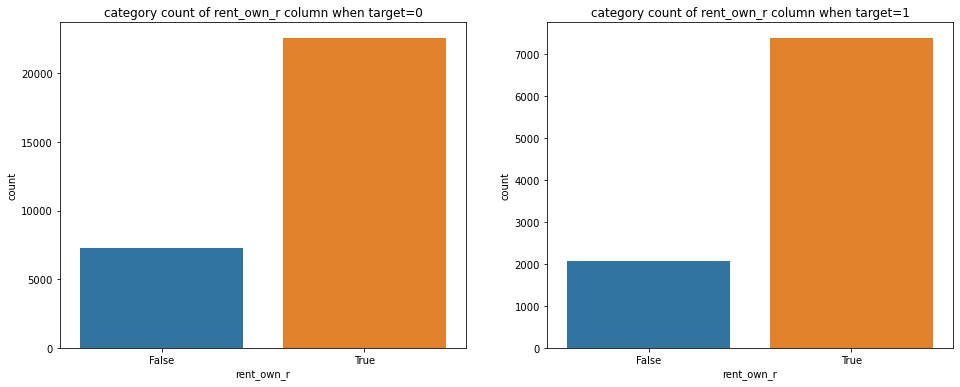

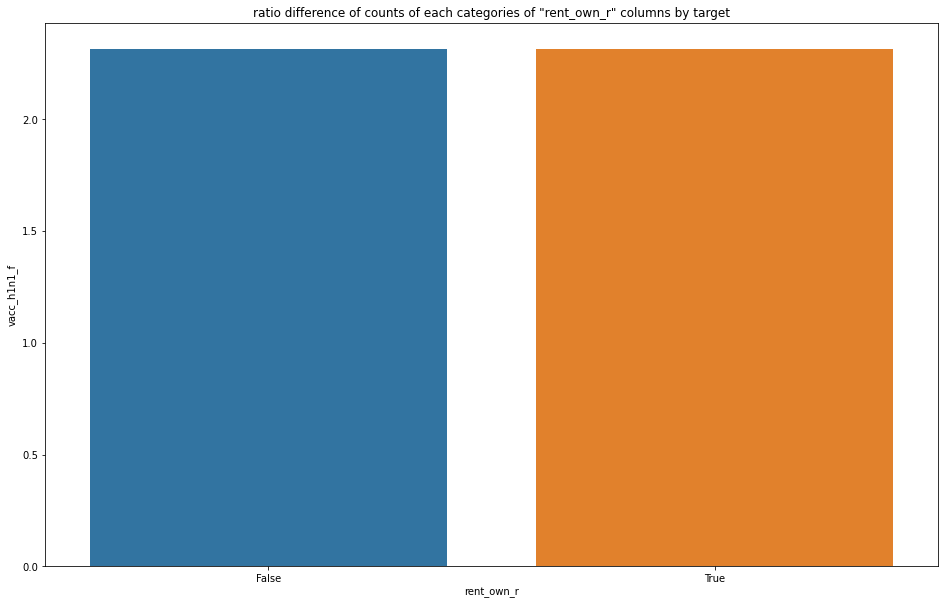

In [68]:
rdplot(df,'rent_own_r')

##### employment_status
Employment status of respondent.   
Qualitative Discrete Ordinal Variable   
Ordinal Encoding : o   
Binning : x   
Reformat : x   
Remarks : x

In [69]:
print(df['employment_status'].unique())
print(df['employment_status'].describe())
df['employment_status'].replace('Unemployed',0,inplace=True)
df['employment_status'].replace('Not in Labor Force',1,inplace=True)
df['employment_status'].replace('Employed',2,inplace=True)
print(df['employment_status'].unique())
print(df['employment_status'].describe())

[nan 'Employed' 'Not in Labor Force' 'Unemployed']
count        31876
unique           3
top       Employed
freq         17173
Name: employment_status, dtype: object
[nan  2.  1.  0.]
count    31876.000000
mean         1.479671
std          0.606419
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: employment_status, dtype: float64


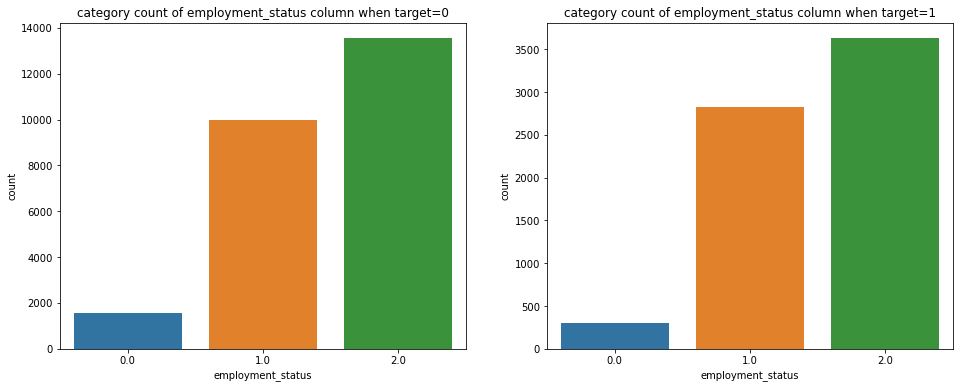

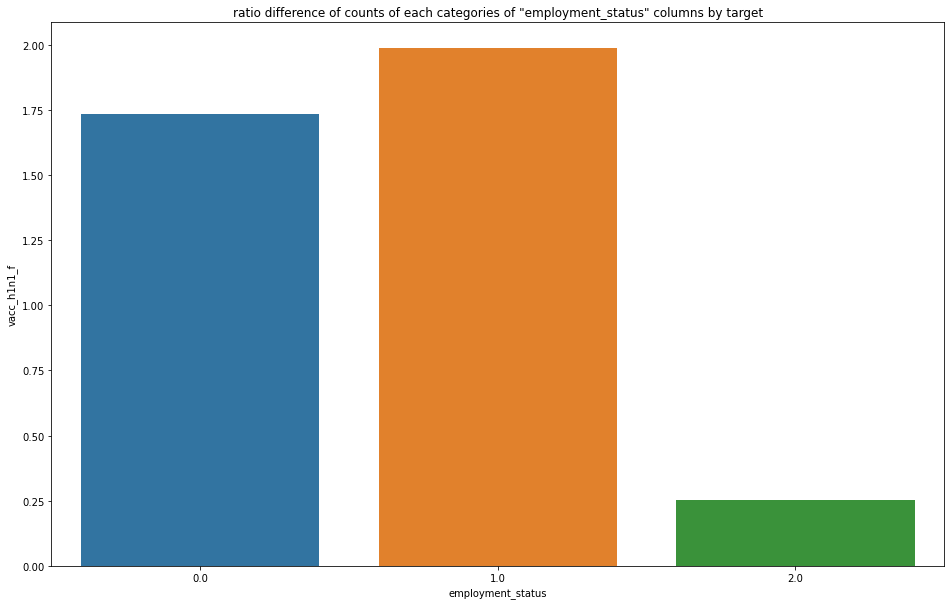

In [70]:
rdplot(df,'employment_status')

##### census_region
True census region of residence   
1=northeast; 2=midwest; 3=south; 4=west   
Qualitative Discrete Normial Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : x   
Remarks : categorical encoding needed, location information

In [71]:
print(df['census_region'].unique())
print(df['census_region'].describe())
df['census_region'].replace(1,'northeast',inplace=True)
df['census_region'].replace(2,'midwest',inplace=True)
df['census_region'].replace(3,'south',inplace=True)
df['census_region'].replace(4,'west',inplace=True)
print(df['census_region'].unique())
print(df['census_region'].describe())
categorical_encoding_needed.append('census_region')

[4 2 1 3]
count    42154.000000
mean         2.706457
std          1.033513
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          4.000000
Name: census_region, dtype: float64
['west' 'midwest' 'northeast' 'south']
count     42154
unique        4
top       south
freq      14664
Name: census_region, dtype: object


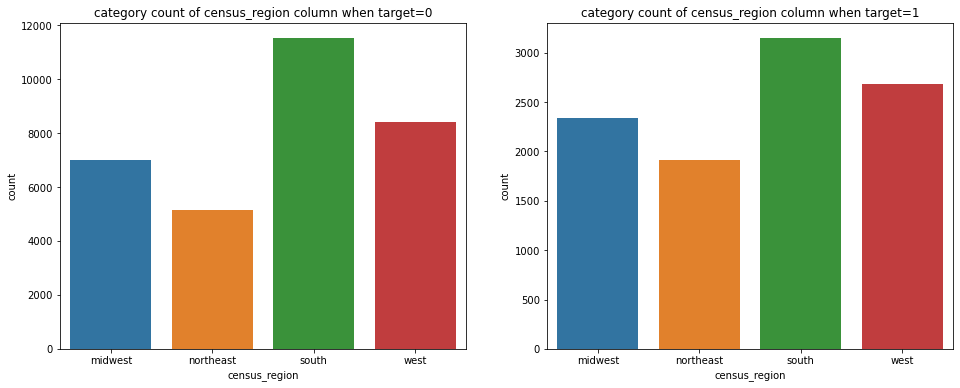

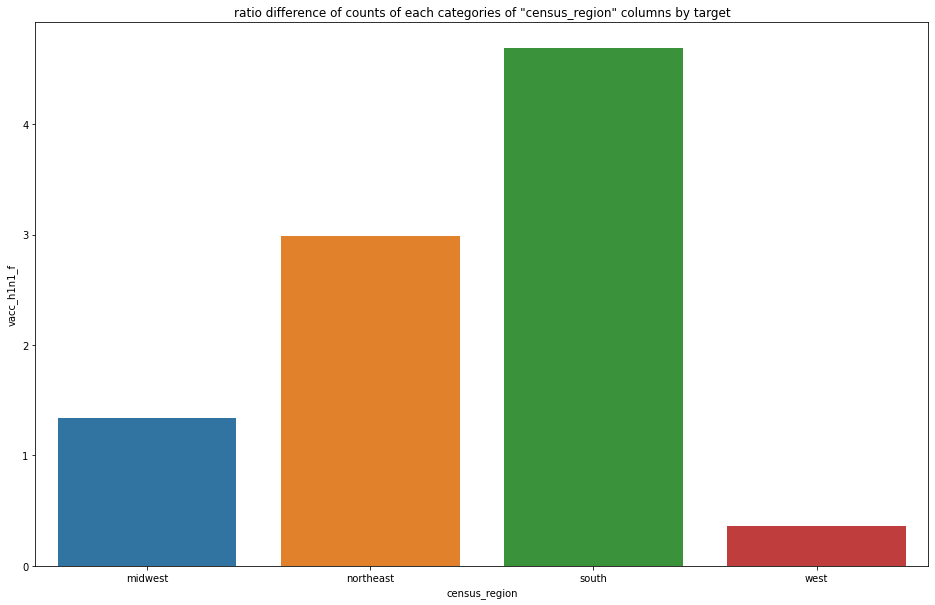

In [72]:
rdplot(df,'census_region')

##### census_msa
Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.   
Qualitative Discrete Ordinal Variable   
Ordinal Encoding : o   
Binning : x   
Reformat : x   
Remarks : x

In [73]:
print(df['census_msa'].unique())
print(df['census_msa'].describe())
df['census_msa'].replace('Non-MSA',0,inplace=True)
df['census_msa'].replace('MSA, Not Principle City',1,inplace=True)
df['census_msa'].replace('MSA, Principle City',2,inplace=True)
print(df['census_msa'].unique())
print(df['census_msa'].describe())

['MSA, Not Principle City' 'MSA, Principle City' 'Non-MSA']
count                       42154
unique                          3
top       MSA, Not Principle City
freq                        18957
Name: census_msa, dtype: object
[1 2 0]
count    42154.000000
mean         1.021991
std          0.741499
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: census_msa, dtype: float64


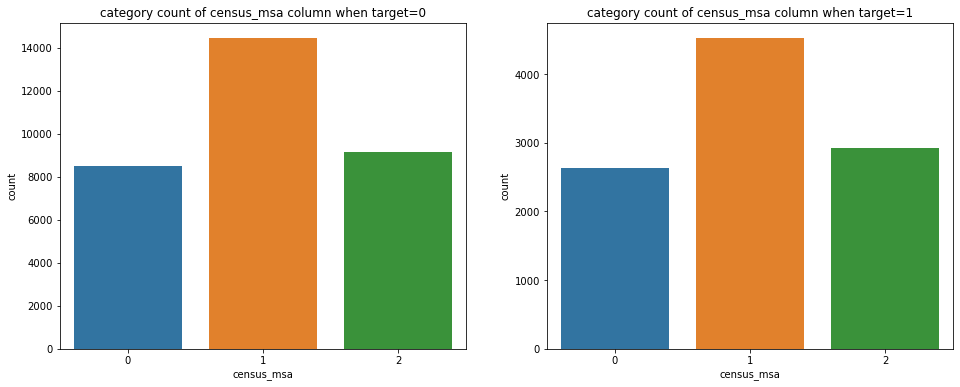

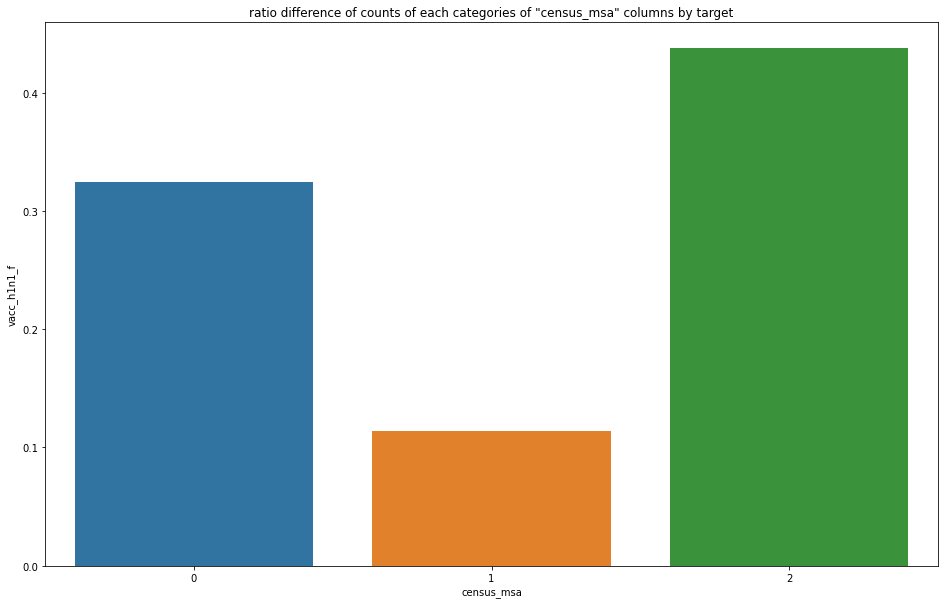

In [74]:
rdplot(df,'census_msa')

##### n_adult_r
Number of other adults in household.   
Quantitive Discrete Ordinal Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : x   
Remarks : x

In [75]:
print(df['n_adult_r'].unique())
df['n_adult_r'].describe()

[ 2.  1.  3.  4. nan]


count    41845.000000
mean         1.937460
std          0.745174
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: n_adult_r, dtype: float64

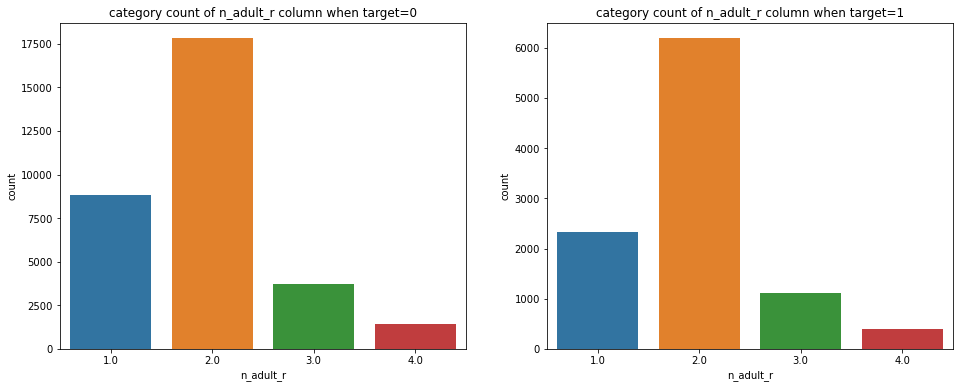

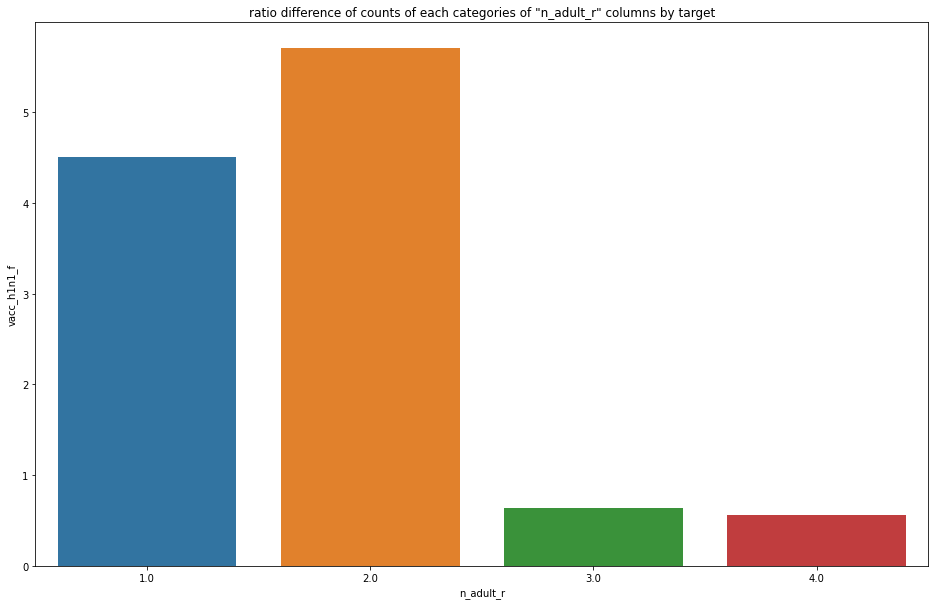

In [76]:
rdplot(df,'n_adult_r')

##### household_children
Number of children in household.   
Quantitive Discrete Ordinal Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : x   
Remarks : x

In [77]:
print(df['household_children'].unique())
df['household_children'].describe()

[ 3.  0.  2.  1. nan]


count    41845.000000
mean         0.797156
std          1.039354
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max          3.000000
Name: household_children, dtype: float64

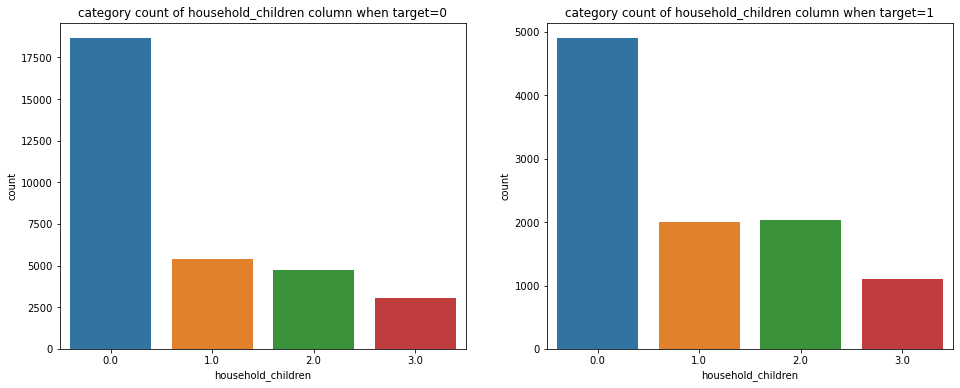

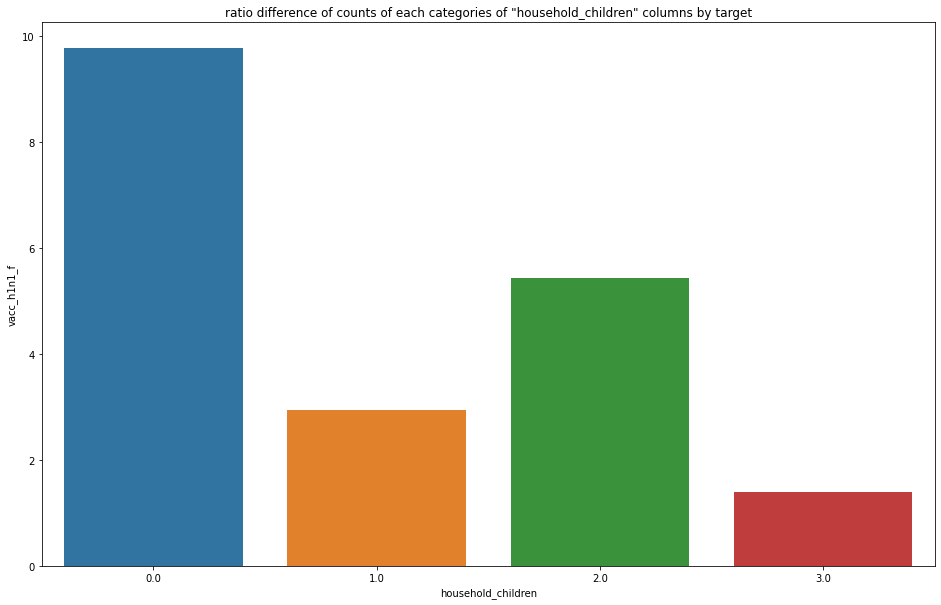

In [78]:
rdplot(df,'household_children')

##### n_people_r
Number of adults in the household.   
Quantitive Discrete Ordinal Variable   
Ordinal Encoding : o   
Binning : x   
Reformat : x   
Remarks : x

In [79]:
print(df['n_people_r'].unique())
df['n_people_r'].describe()

[ 5.  1.  3.  4.  2.  6. nan  7.]


count    42020.000000
mean         2.738505
std          1.393333
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max          7.000000
Name: n_people_r, dtype: float64

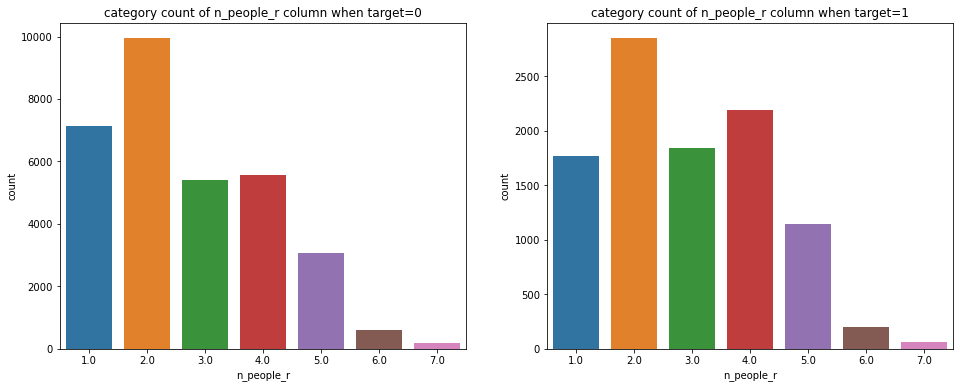

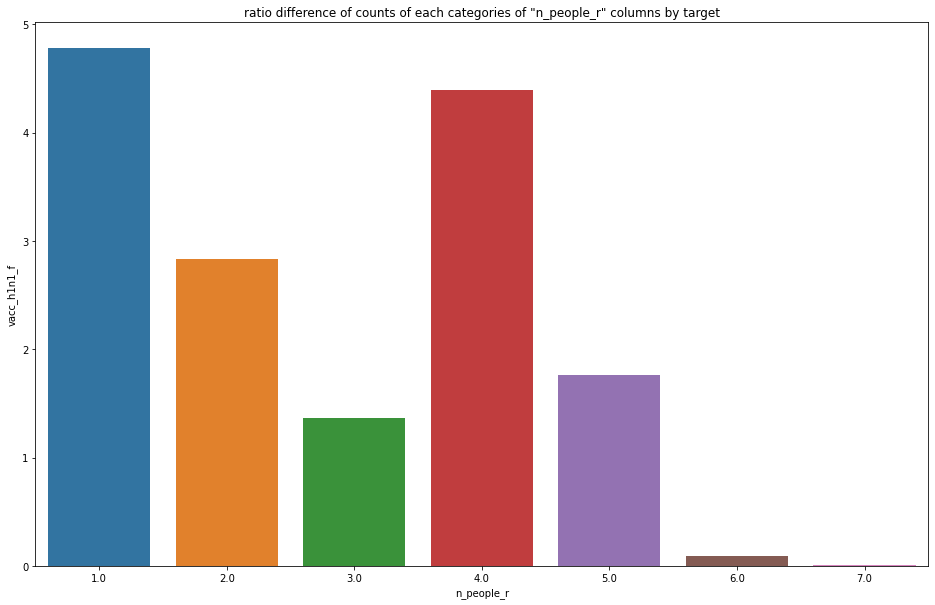

In [80]:
rdplot(df,'n_people_r')

##### employment_industry
Type of industry respondent is employed in.   
Qualitative Discrete Normial Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : x   
Remarks : Refused, classified -> np.nan, high cardinality

In [81]:
print(df['employment_industry'].unique())
print(df['employment_industry'].describe())
df['employment_industry'].replace('Refused, classified',np.nan,inplace=True)
df['employment_industry'].replace('Not ascertained',np.nan,inplace=True)
print(df['employment_industry'].unique())
print(df['employment_industry'].describe())
categorical_encoding_needed.append('employment_industry')

[nan 'Accommodation and Food Services Industries'
 'Transportation and Warehousing Industries'
 'Professional, Scientific, and Technical Services Industries'
 'Education Services Industries' 'Other Services (except Public)'
 'Construction Industries' 'Manufacturing Industries' 'Not ascertained'
 'Arts, Entertainment, and Recreation Industries Administration'
 'Retail Trade Industries'
 'Administrative and Support and Waste Management'
 'Information Industries' 'Health Care and Social Assistance Industries'
 'Refused, classified' 'Utilities Industries'
 'Real Estate and Rental and Leasing Industries'
 'Agriculture, Forestry, Fishing, and Hunting Industries'
 'Public Administration Industries' 'Finance and Insurance Industries'
 'Armed Forces' 'Mining Industries' 'Wholesale Trade Industries'
 'Management of Companies and Enterprises Industries']
count                                            17165
unique                                              23
top       Health Care and Social A

In [82]:
print(df[df['employment_status']==False]['employment_industry'].unique())
for i in range(len(df)):
    if df['employment_status'][i]==False:
        df['employment_industry'][i]='Homekeeper'
print(df[df['employment_status']==False]['employment_industry'].unique())

[nan]


<ipython-input-82-db97cc64416d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['employment_industry'][i]='Homekeeper'


['Homekeeper']


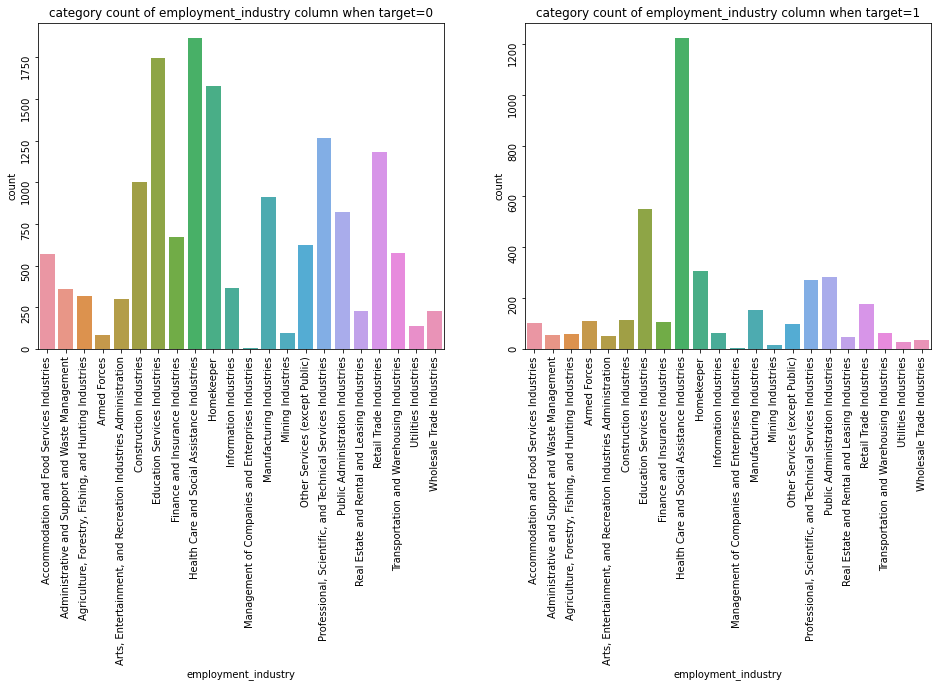

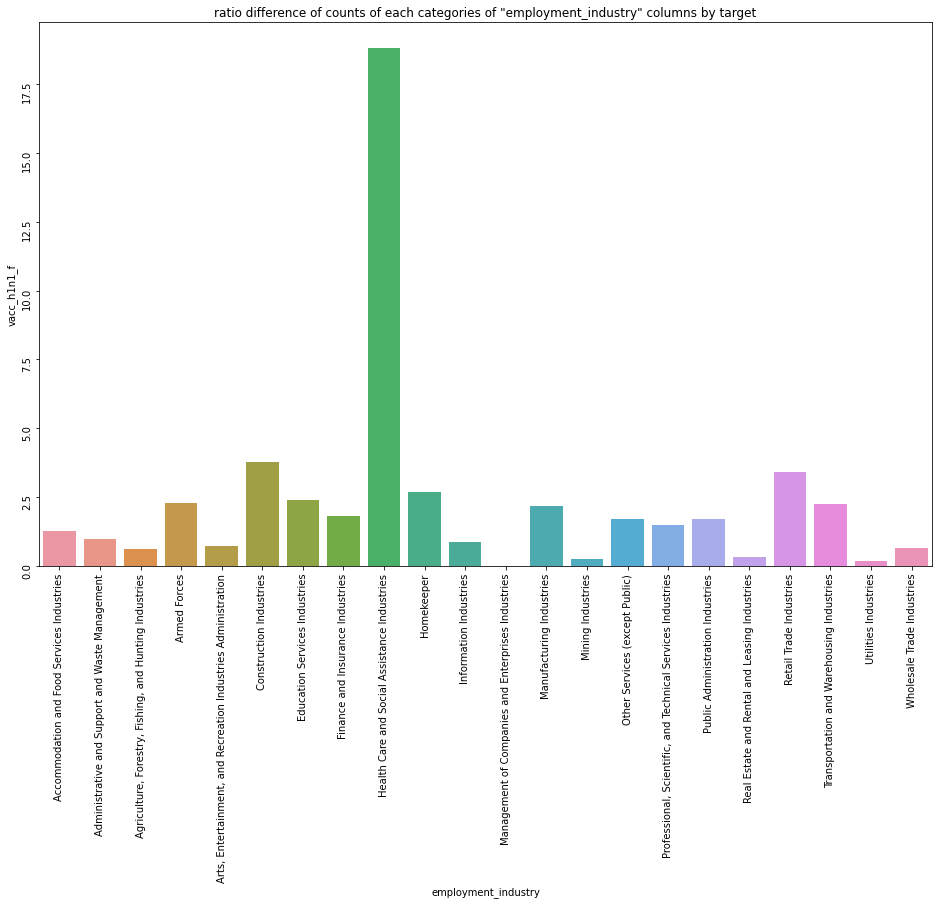

In [83]:
rdplot(df,'employment_industry',rot=90)

##### employment_occupation
Type of occupation of respondent. Values are represented as short random character strings.   
Qualitative Discrete Normial Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : x   
Remarks : Refused, classified -> np.nan, high cardinality

In [84]:
print(df['employment_occupation'].unique())
print(df['employment_occupation'].describe())
df['employment_occupation'].replace('Refused, classified',np.nan,inplace=True)
df['employment_occupation'].replace('Not ascertained',np.nan,inplace=True)
print(df['employment_occupation'].unique())
print(df['employment_occupation'].describe())
categorical_encoding_needed.append('employment_occupation')

[nan 'Food Preparation and Serving Related Occupations'
 'Transportation and Material Moving Occupations' 'Legal Occupations'
 'Office and Administrative Support Occupations' 'Not ascertained'
 'Management Occupations' 'Architecture and Engineering Occupations'
 'Business and Financial Operations Occupations'
 'Building and Grounds Cleaning and Maintenance Occupations'
 'Sales and Related Occupations'
 'Life, Physical, and Social Science Occupations'
 'Education, Training, and Library Occupations'
 'Arts, Design, Entertainment, Sports and Media Occupations'
 'Construction and Extraction Occupations'
 'Healthcare Practitioners and Technical Occupations'
 'Community and Social Services Occupations'
 'Computer and Mathematical Occupations'
 'Personal Care and Service Occupations' 'Production Occupations'
 'Installation, Maintenance, and Repair Occupations'
 'Healthcare Support Occupations' 'Refused, classified'
 'Protective Service Occupations' 'Military Specific Occupations'
 'Farming, F

In [85]:
print(df[df['employment_status']==False]['employment_occupation'].unique())
for i in range(len(df)):
    if df['employment_status'][i]==False:
        df['employment_occupation'][i]='Homekeeper'
print(df[df['employment_status']==False]['employment_occupation'].unique())

[nan]


<ipython-input-85-7b172cbd47da>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['employment_occupation'][i]='Homekeeper'


['Homekeeper']


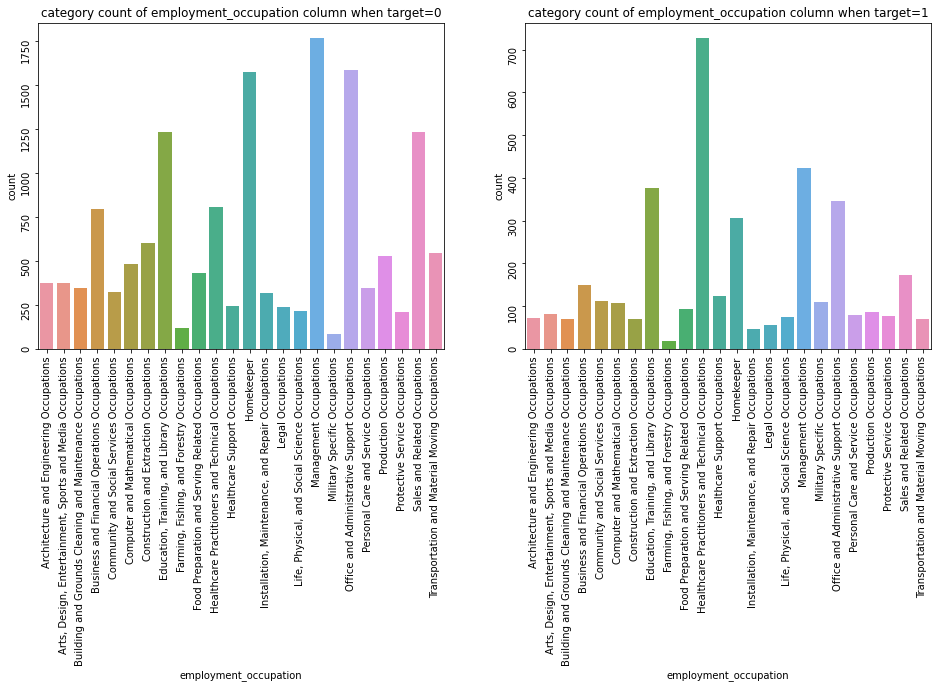

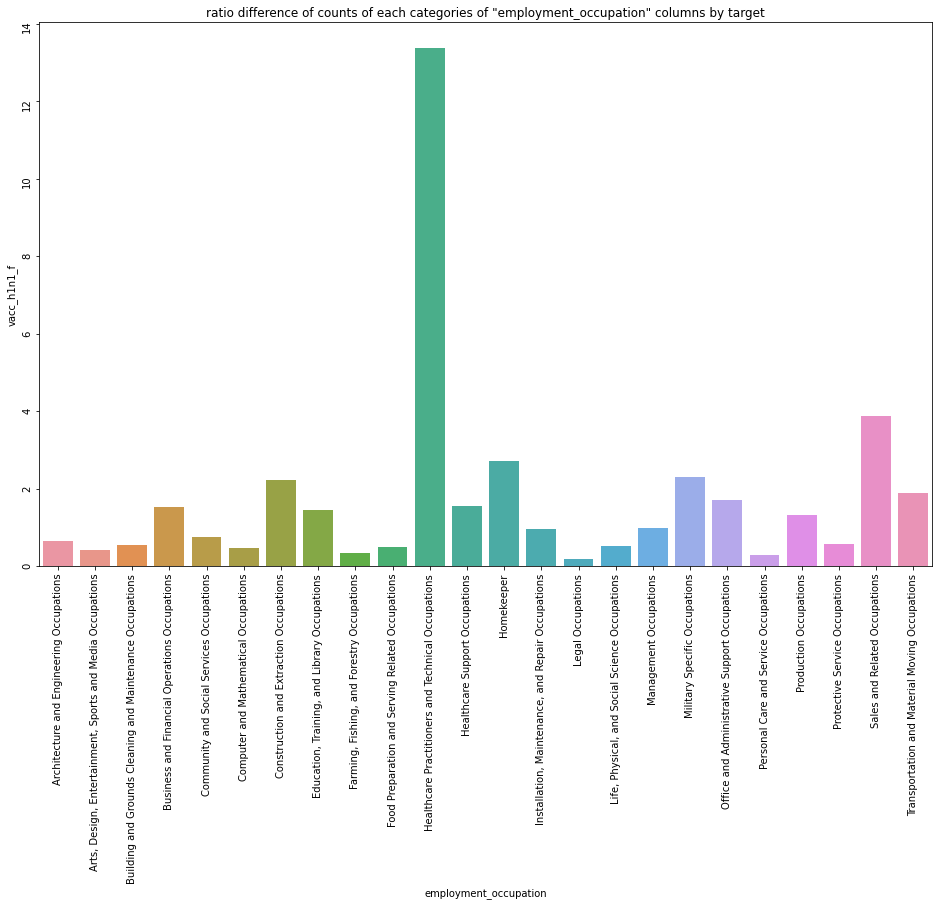

In [86]:
rdplot(df,'employment_occupation',rot=90)

##### hhs_region
HHS surveillance region number   
    - Region 1: CT,ME,MA,NH,RI,VT   
    - Region 2: NJ,NY   
    - Region 3: DE,DC,MD,PA,VA,WV   
    - Region 4: AL,FL,GA,KY,MS,NC,SC,TN   
    - Region 5: IL,IN,MI,MN,OH,WI   
    - Region 6: AR,LA,NM,OK,TX   
    - Region 7: IA,KS,MO,NE   
    - Region 8: CO,MT,ND,SD,UT,WY   
    - Region 9: AZ,CA,HI,NV   
    - Region 10: AK,ID,OR,WA   
Qualitative Discrete Normial Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : x   
Remarks : categorical encoding needed, location information

In [87]:
print(df['hhs_region'].unique())
print(df['hhs_region'].describe())
df['hhs_region']=df['hhs_region'].map(lambda x: 'Region'+str(x))
print(df['hhs_region'].unique())
print(df['hhs_region'].describe())
categorical_encoding_needed.append('hhs_region')

[ 9  7  1  6  4  8  5  3  2 10]
count    42154.000000
mean         5.352991
std          2.705101
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         10.000000
Name: hhs_region, dtype: float64
['Region9' 'Region7' 'Region1' 'Region6' 'Region4' 'Region8' 'Region5'
 'Region3' 'Region2' 'Region10']
count       42154
unique         10
top       Region4
freq         6751
Name: hhs_region, dtype: object


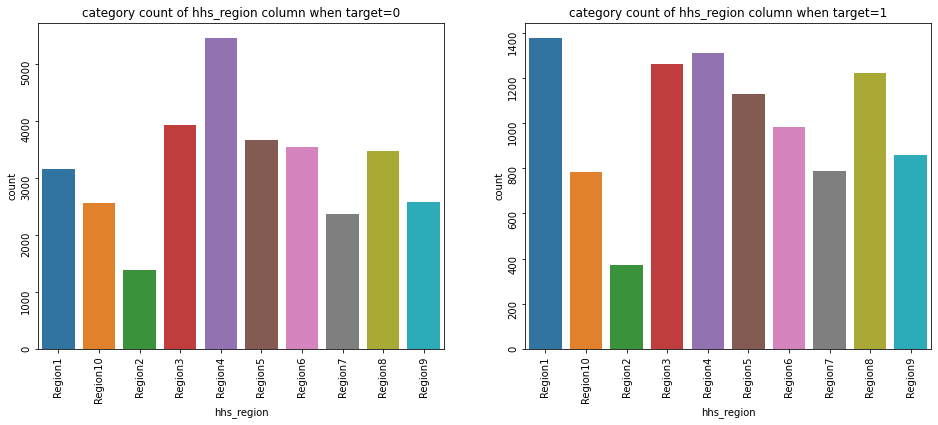

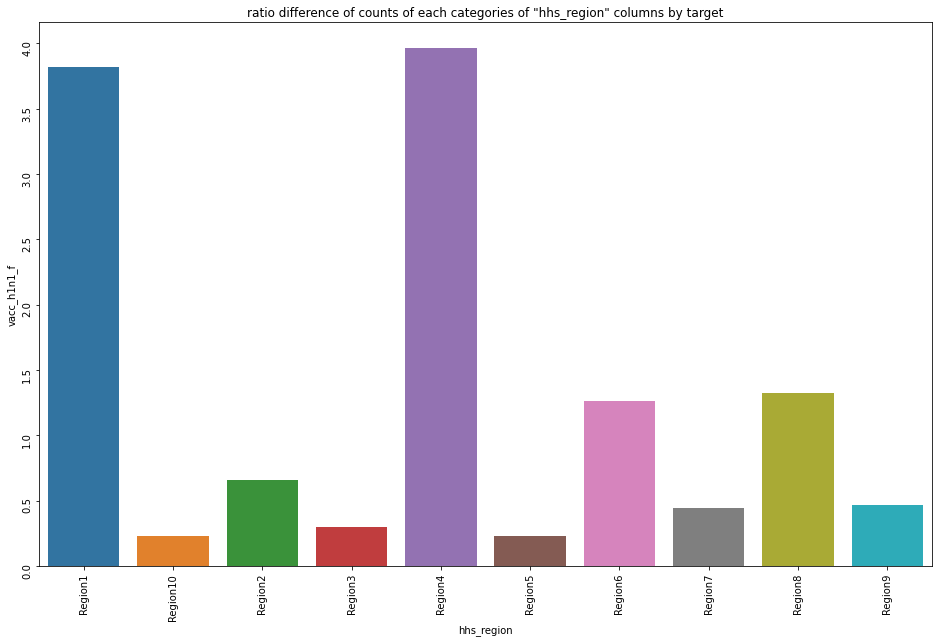

In [88]:
rdplot(df,'hhs_region',rot=90)

##### state
State of residence   
Qualitative Discrete Normial Variable   
Ordinal Encoding : x   
Binning : x   
Reformat : x   
Remarks : categorical encoding needed, location information

In [89]:
print(df['state'].unique())
df['state'].describe()
categorical_encoding_needed.append('state')

['CALIFORNIA' 'NEBRASKA' 'MASSACHUSETTS' 'LOUISIANA' 'ALABAMA' 'MONTANA'
 'MISSOURI' 'WISCONSIN' 'FLORIDA' 'MARYLAND' 'NEVADA' 'PENNSYLVANIA'
 'RHODE ISLAND' 'ARIZONA' 'MAINE' 'SOUTH DAKOTA' 'WYOMING' 'CONNECTICUT'
 'DELAWARE' 'NEW YORK' 'SOUTH CAROLINA' 'NEW JERSEY' 'NORTH CAROLINA'
 'DISTRICTOF COLUMBIA' 'NEW HAMPSHIRE' 'TEXAS' 'OREGON' 'KENTUCKY'
 'NORTH DAKOTA' 'TENNESSEE' 'INDIANA' 'WASHINGTON' 'MISSISSIPPI'
 'WEST VIRGINIA' 'MINNESOTA' 'HAWAII' 'VIRGINIA' 'ARKANSAS' 'ALASKA'
 'OKLAHOMA' 'KANSAS' 'NEW MEXICO' 'VERMONT' 'ILLINOIS' 'MICHIGAN' 'IDAHO'
 'UTAH' 'GEORGIA' 'IOWA' 'OHIO' 'COLORADO']


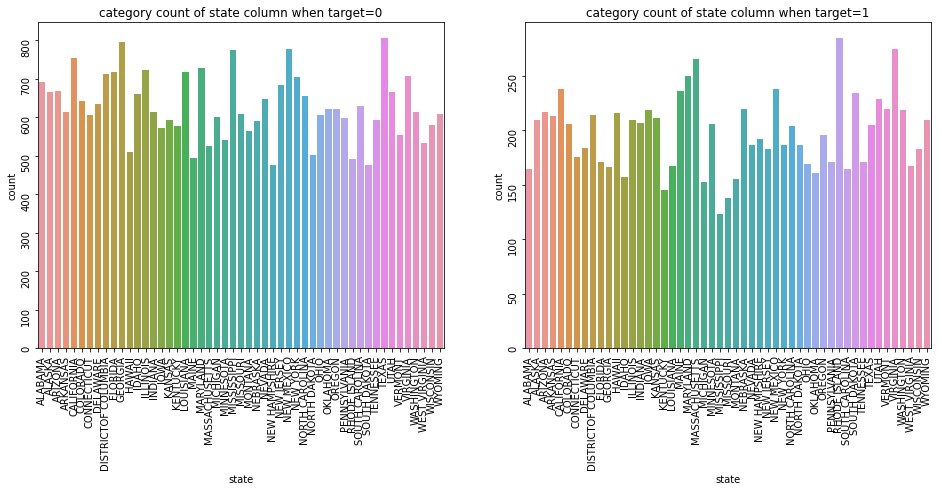

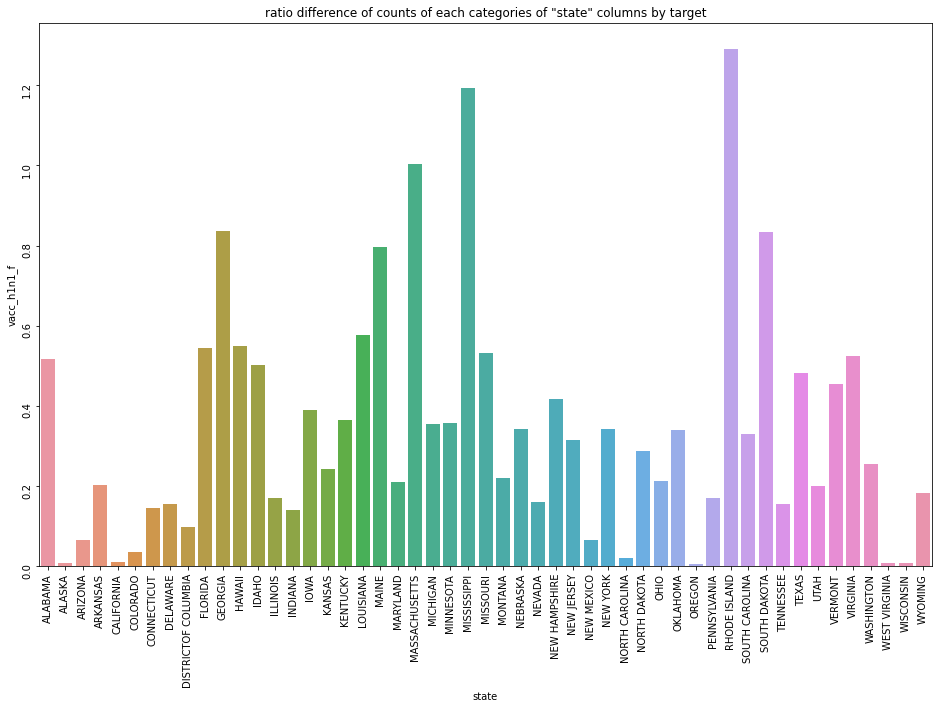

In [90]:
rdplot(df,'state',rot=90)

### Missing Values

#### Exploring Missing Values

<AxesSubplot:>

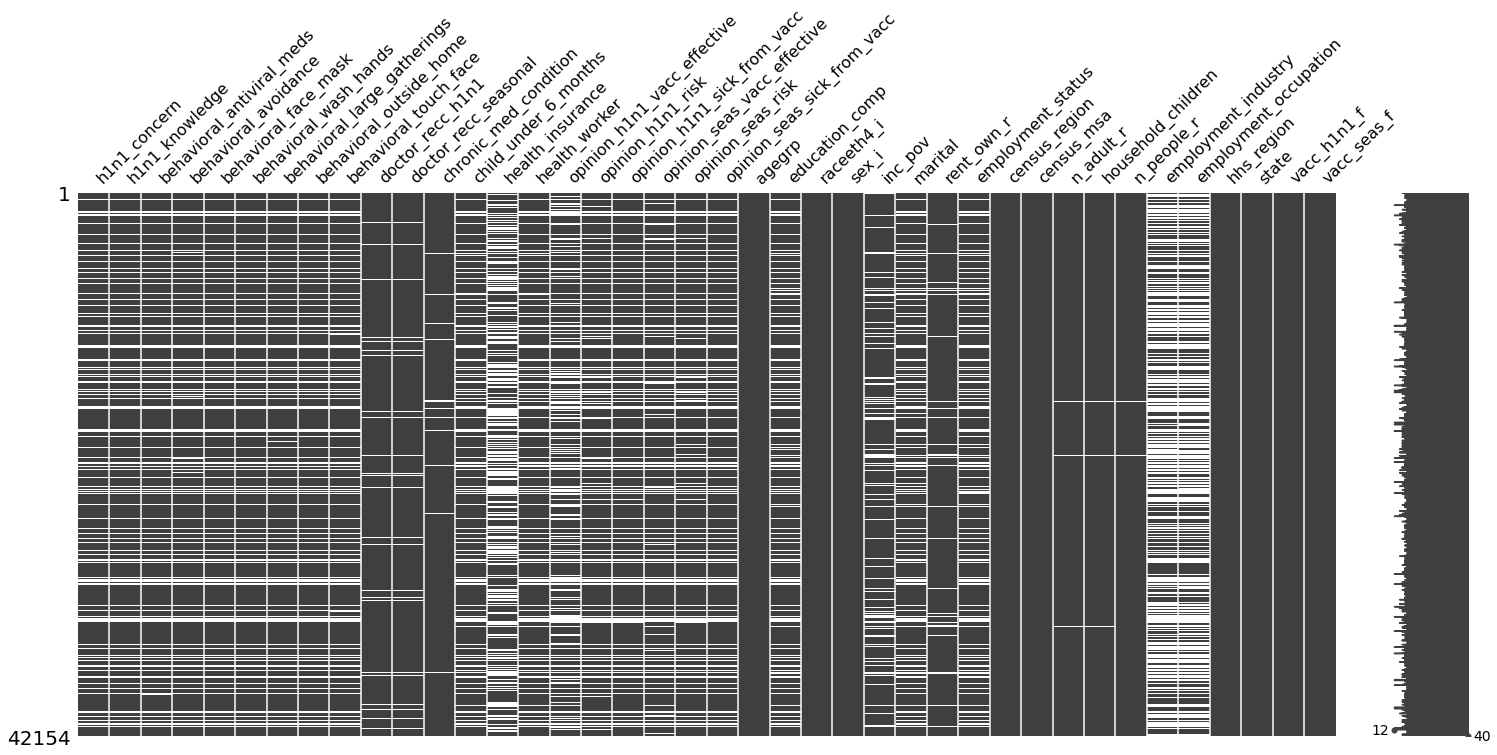

In [91]:
msno.matrix(df)

<AxesSubplot:>

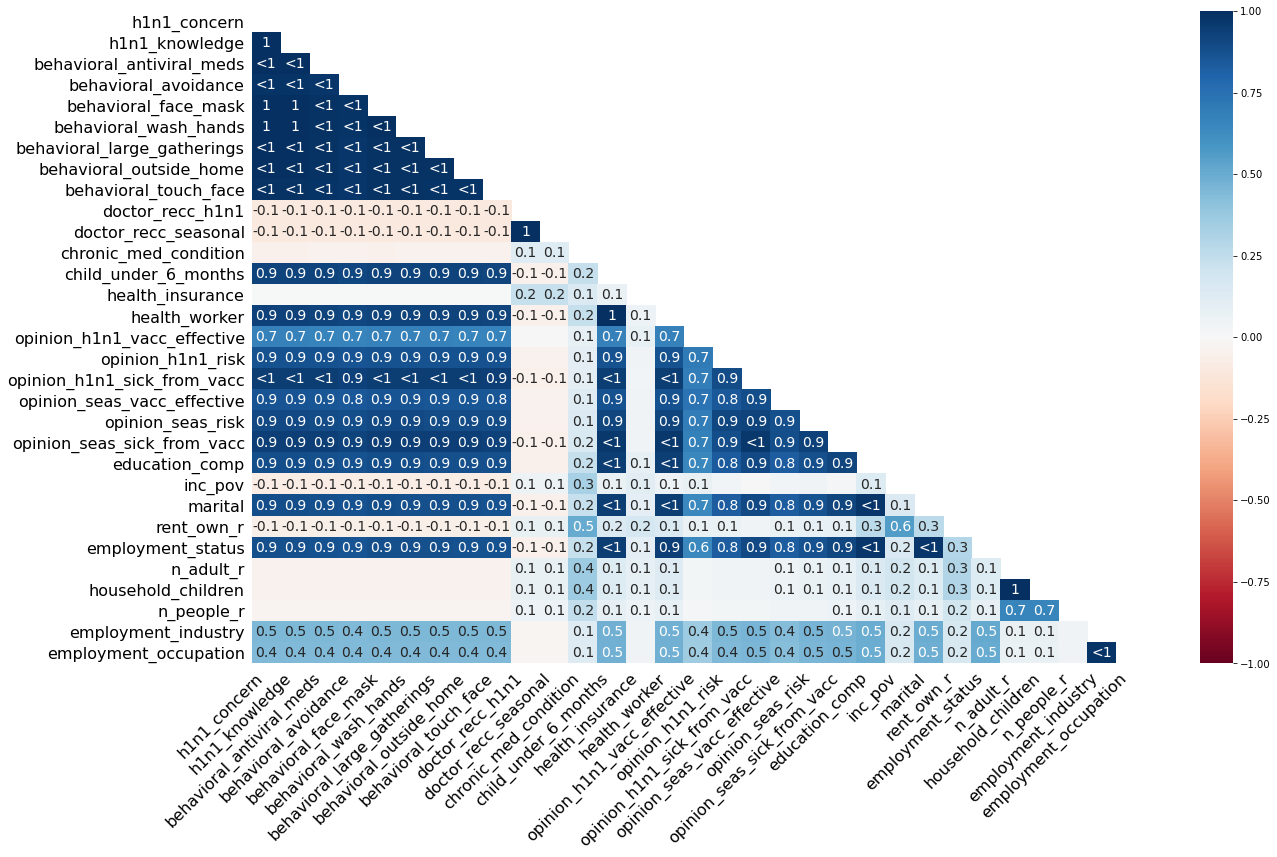

In [92]:
msno.heatmap(df)

we can see features share patterns   
- pattern_A
    - h1n1_concern
    - h1n1_knowledge
    - behavioral_antiviral_meds
    - behavioral_avoidance
    - behavioral_face_mask
    - behavioral_wash_hands
    - behavioral_large_gatherings
    - behavioral_outside_home
    - behavioral_touch_face
    - child_under_6_months
    - health_worker
    - opinion_h1n1_vacc_effective *
    - opinion_h1n1_risk
    - opinion_h1n1_sick_from_vacc
    - opinion_seas_vacc_effective
    - opinion_seas_risk
    - opinion_seas_sick_from_vacc
    - education_comp
    - marital
    - employment_status
- pattern_B
    - doctor_recc_h1n1
    - doctor_recc_seasonal
- pattern_C
    - n_adult_r
    - househole_children
    - n_people_r
- pattern_D
    - employment_industry
    - employment_occupation

    
chronic_med_condition, health_insurance, inc_pov, rent_own_r -> maybe MCAR 

##### response rate

total number of query : 38


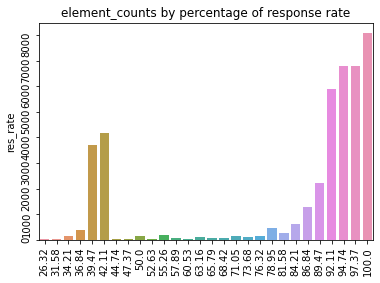

In [93]:
# response rate
nq=len(df.columns)-2
print(f'total number of query : {nq}')
df.isna().sum(axis=1)
df['res_rate']=df.isna().sum(axis=1).apply(lambda x: round((nq-x)/nq*100,2))
response=df['res_rate'].value_counts()
ax=sns.barplot(x=response.index,y=response)
ax.tick_params(rotation=90)
ax.set_title('element_counts by percentage of response rate');

In [94]:
#lazy people(the "res_rate<37"s) look minor and not important
#ProfileReport(df[df['res_rate']<37], title="Lazy people Profiling Report", explorative=True)

##### dummy variable of missing values

In [95]:
#dummy variable of missing values
df_MV=df[:].isna()
df_MV.columns=df_MV.columns.map(lambda x: f'{x}_mv')
for i in df_MV.columns:
    if df_MV[i].var()==0:
        df_MV.drop([i],axis=1,inplace=True)
#ProfileReport(df_MV, title="Missing values Profiling Report", explorative=True)

#### Handling Structurally missing data

<AxesSubplot:>

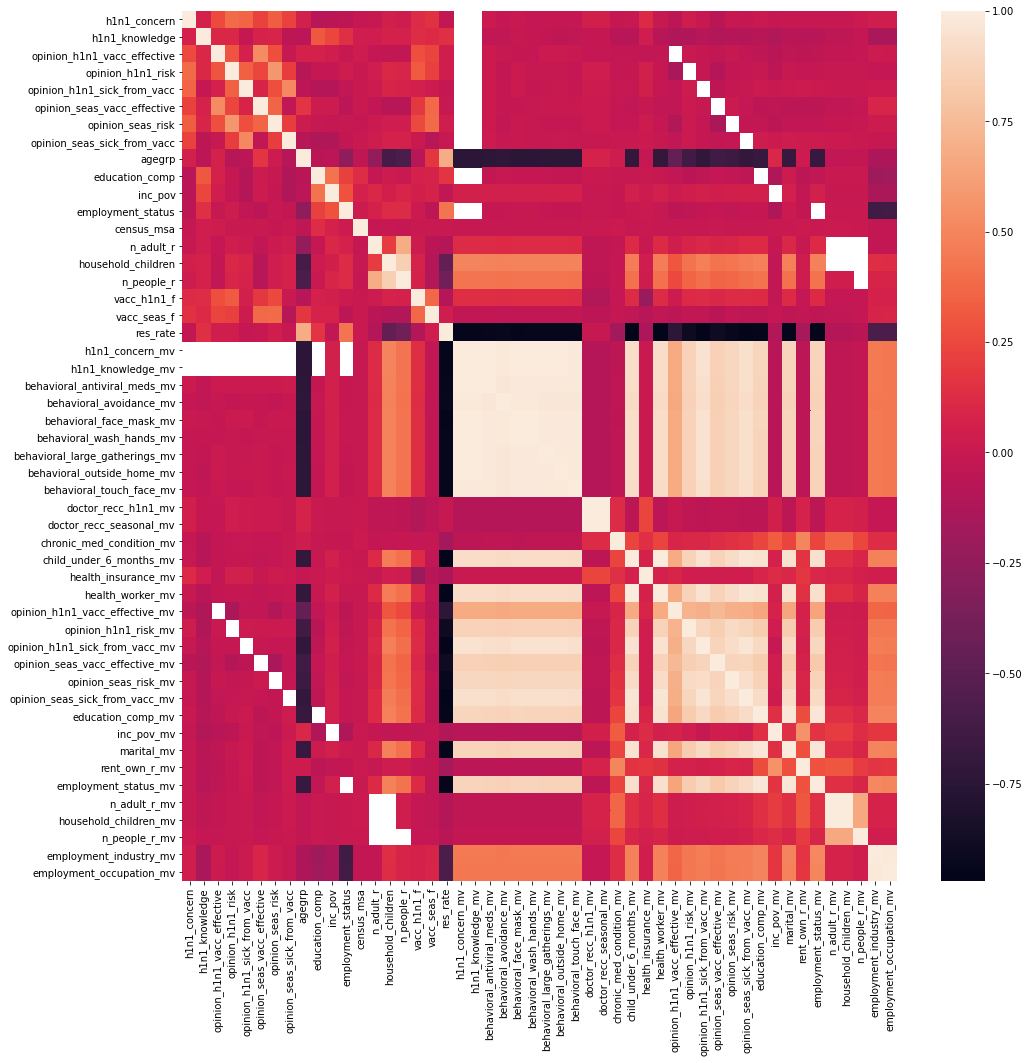

In [96]:
df_MV_corr=pd.concat([df,df_MV],axis=1)
df_MV_corr=df_MV_corr.corr()
fig, axs = plt.subplots(figsize=(16,16),nrows=1,ncols=1)
sns.heatmap(data=df_MV_corr,ax=axs)

maybe we can fill some MVs with age_group
- 1: '6 Months - 9 Years'
- 2: '10 - 17 Years'
- 3: '18 - 34 Years'
- 4: '35 - 44 Years'
- 5: '45 - 54 Years'
- 6: '55 - 64 Years'
- 7: '65+ Years'


In [97]:
#result means the number of MVs
df_age=pd.concat([df['agegrp'],df_MV],axis=1).groupby(by='agegrp').sum()
for i in df_age.columns:
    print(i)
    print(dict(df_age[i]))

h1n1_concern_mv
{1: 4330, 2: 4090, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
h1n1_knowledge_mv
{1: 4330, 2: 4090, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
behavioral_antiviral_meds_mv
{1: 4330, 2: 4090, 3: 14, 4: 11, 5: 18, 6: 9, 7: 47}
behavioral_avoidance_mv
{1: 4330, 2: 4090, 3: 17, 4: 18, 5: 42, 6: 66, 7: 109}
behavioral_face_mask_mv
{1: 4330, 2: 4090, 3: 5, 4: 2, 5: 3, 6: 7, 7: 7}
behavioral_wash_hands_mv
{1: 4330, 2: 4090, 3: 8, 4: 5, 5: 11, 6: 5, 7: 22}
behavioral_large_gatherings_mv
{1: 4330, 2: 4090, 3: 11, 4: 7, 5: 10, 6: 19, 7: 47}
behavioral_outside_home_mv
{1: 4330, 2: 4090, 3: 12, 4: 8, 5: 14, 6: 19, 7: 48}
behavioral_touch_face_mv
{1: 4330, 2: 4090, 3: 17, 4: 12, 5: 20, 6: 33, 7: 81}
doctor_recc_h1n1_mv
{1: 17, 2: 18, 3: 372, 4: 273, 5: 342, 6: 383, 7: 480}
doctor_recc_seasonal_mv
{1: 17, 2: 18, 3: 372, 4: 273, 5: 342, 6: 383, 7: 480}
chronic_med_condition_mv
{1: 68, 2: 53, 3: 277, 4: 199, 5: 209, 6: 205, 7: 306}
child_under_6_months_mv
{1: 4330, 2: 4090, 3: 265, 4: 195, 5: 179, 6: 170, 7: 220

In [98]:
#1,2,7그룹으로 결측치 채우기
for i in range(len(df)):
    if df['agegrp'][i] in (1,2):
        df['education_comp'][i]=1
        df['marital'][i]=False
        df['employment_status'][i]=0
        df['employment_industry'][i]='student'
        df['employment_occupation'][i]='student'
    elif df['agegrp'][i] ==7:
        df['employment_status'][i]=False
        df['employment_industry'][i]='homekeeper'
        df['employment_occupation'][i]='homekeeper'
pass;

<ipython-input-98-75f043a65d4d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['education_comp'][i]=1
<ipython-input-98-75f043a65d4d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['marital'][i]=False
<ipython-input-98-75f043a65d4d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['employment_status'][i]=0
<ipython-input-98-75f043a65d4d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

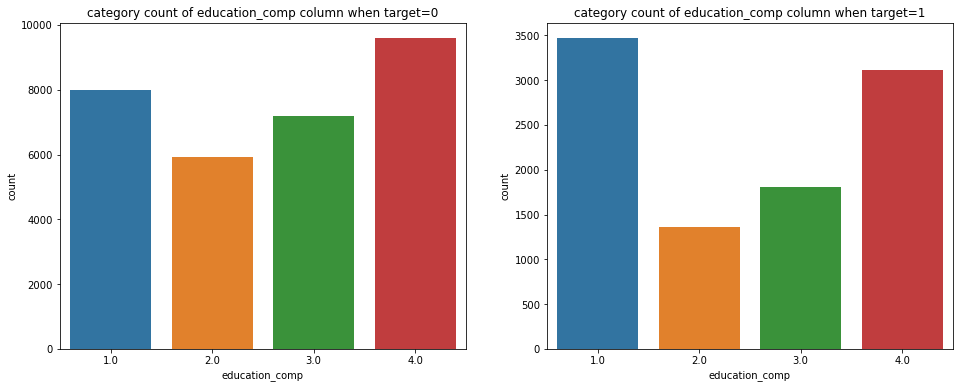

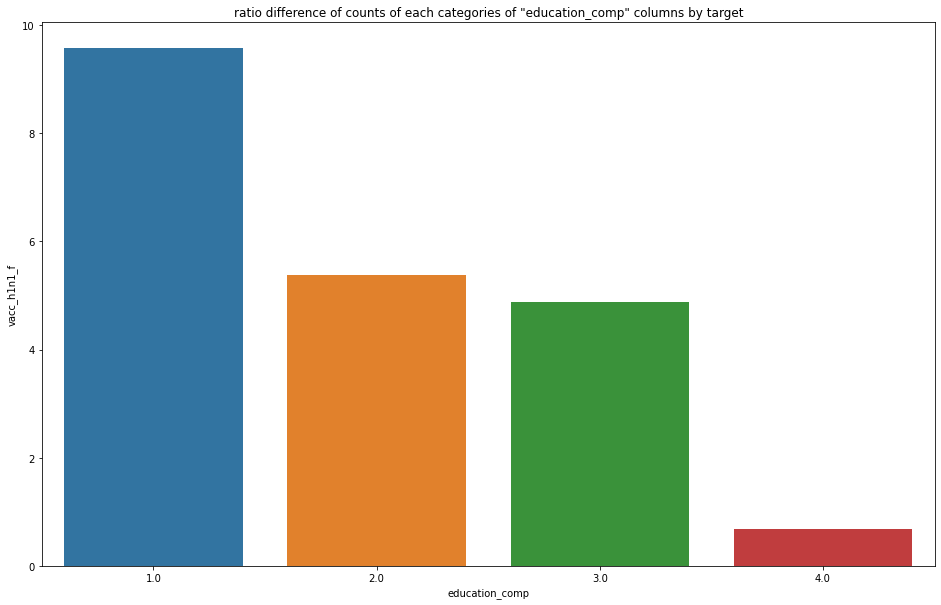

In [99]:
rdplot(df,'education_comp')

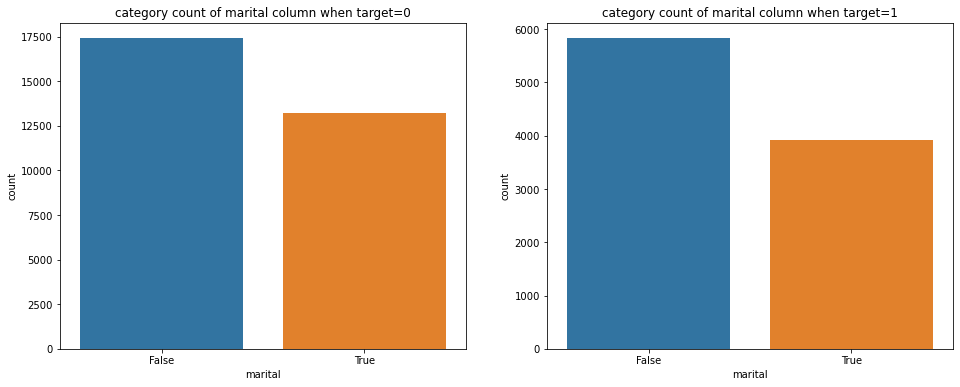

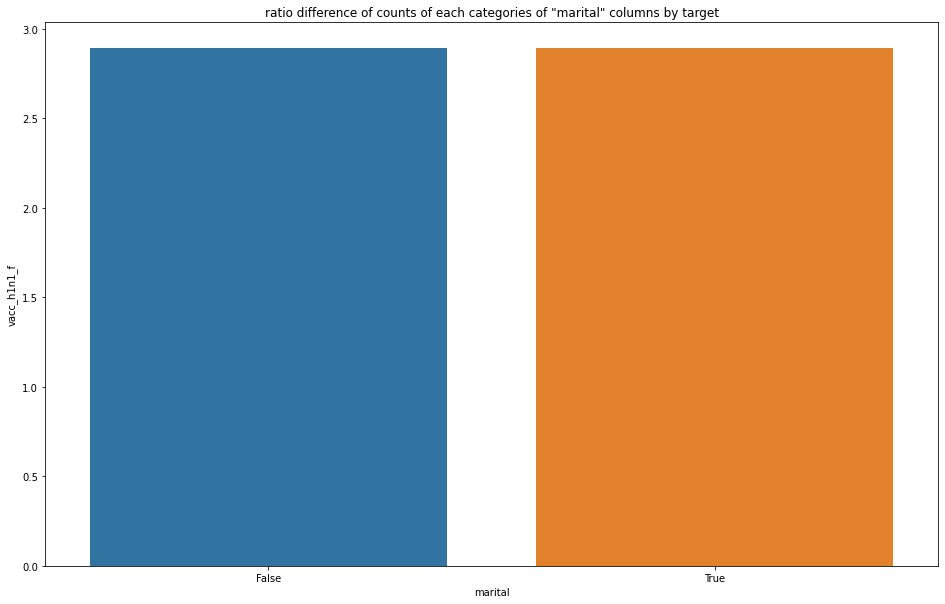

In [100]:
rdplot(df,'marital')

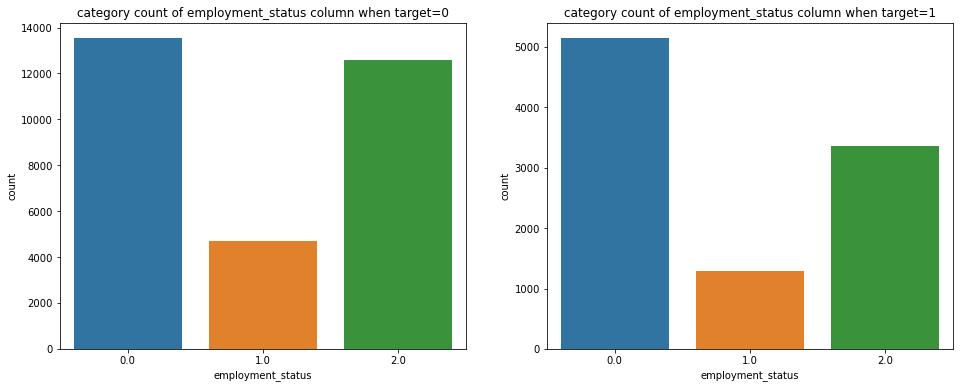

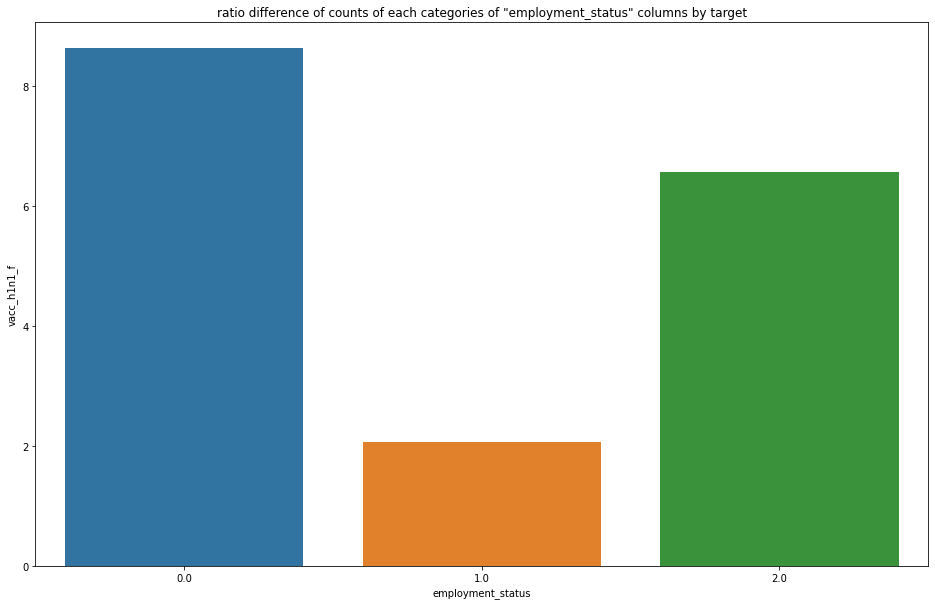

In [101]:
rdplot(df,'employment_status')

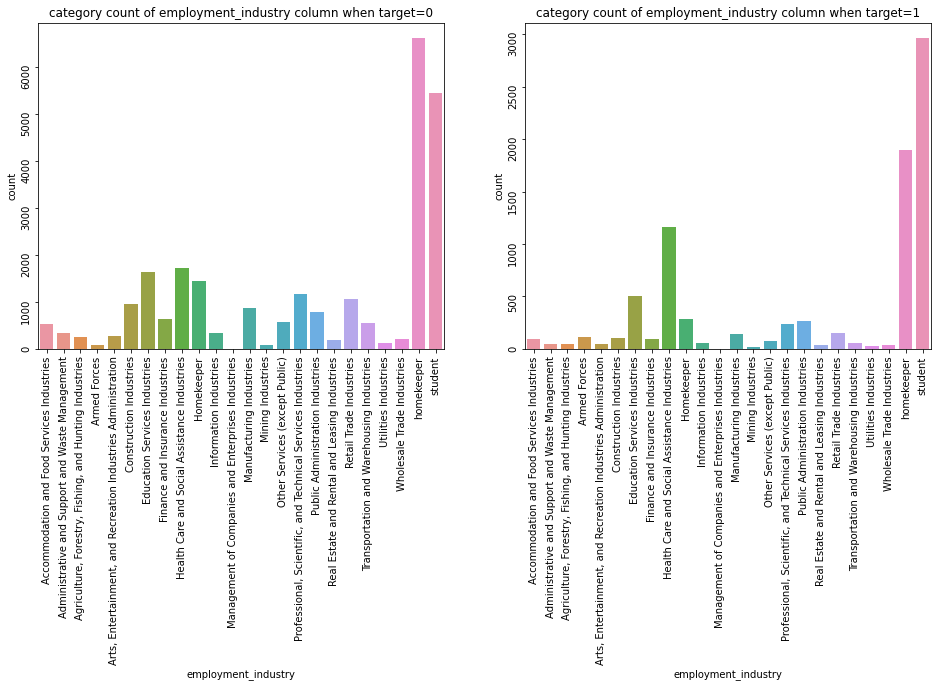

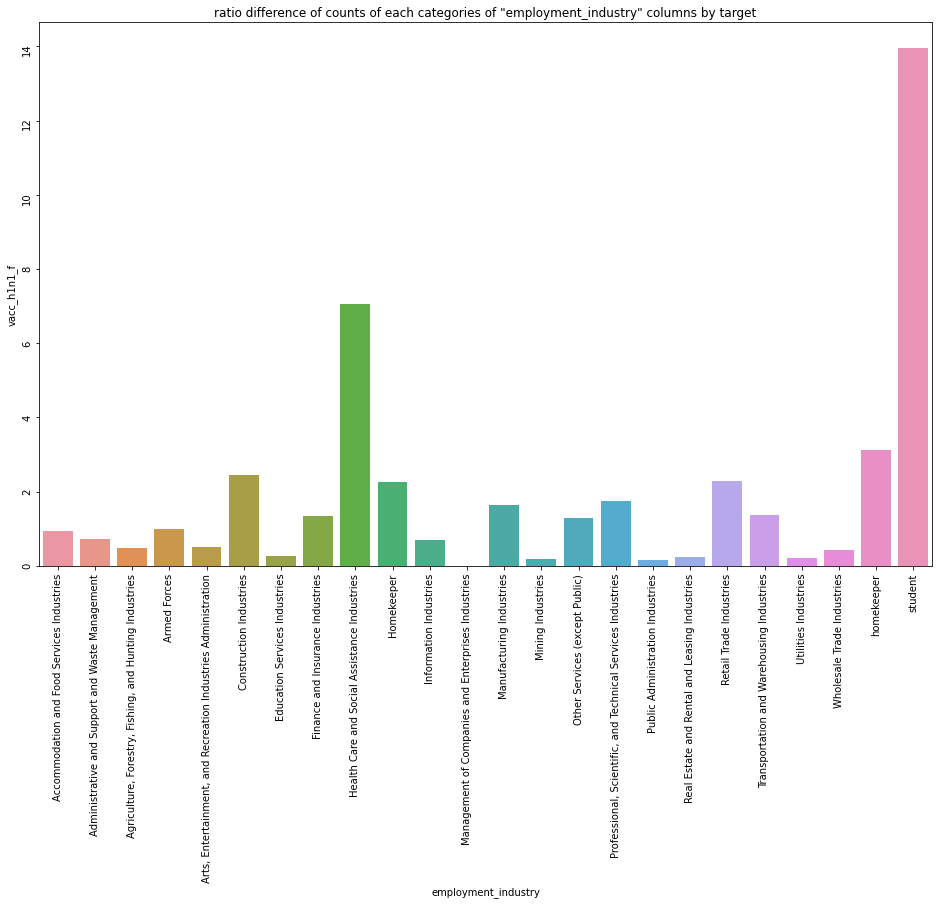

In [102]:
rdplot(df,'employment_industry',rot=90)

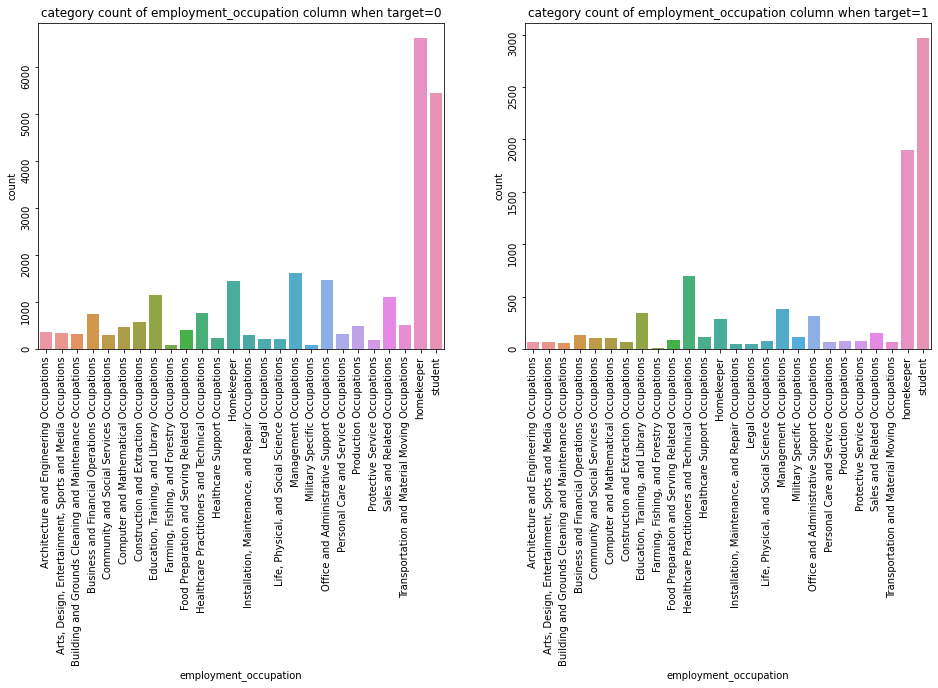

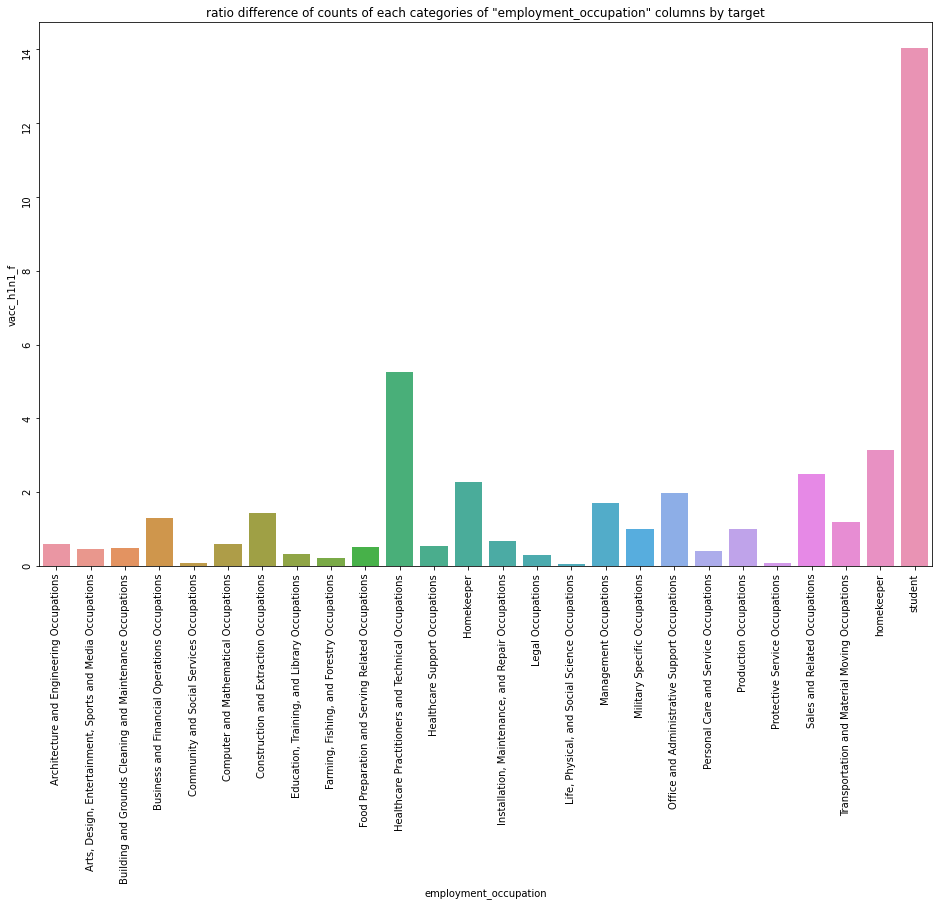

In [103]:
rdplot(df,'employment_occupation',rot=90)

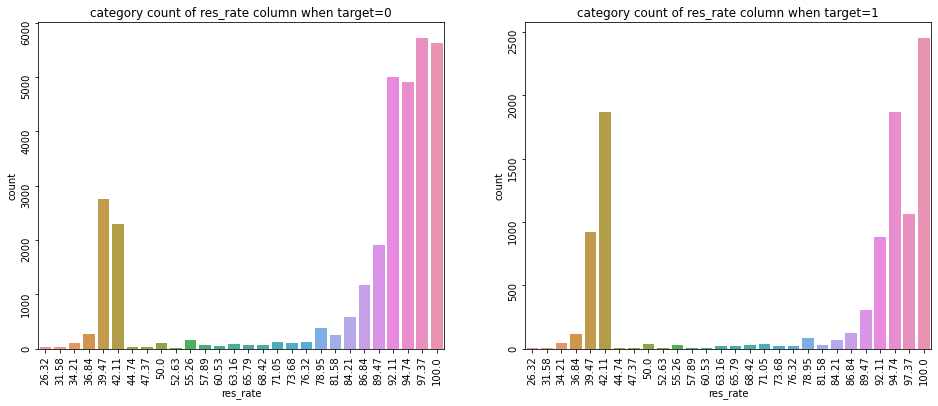

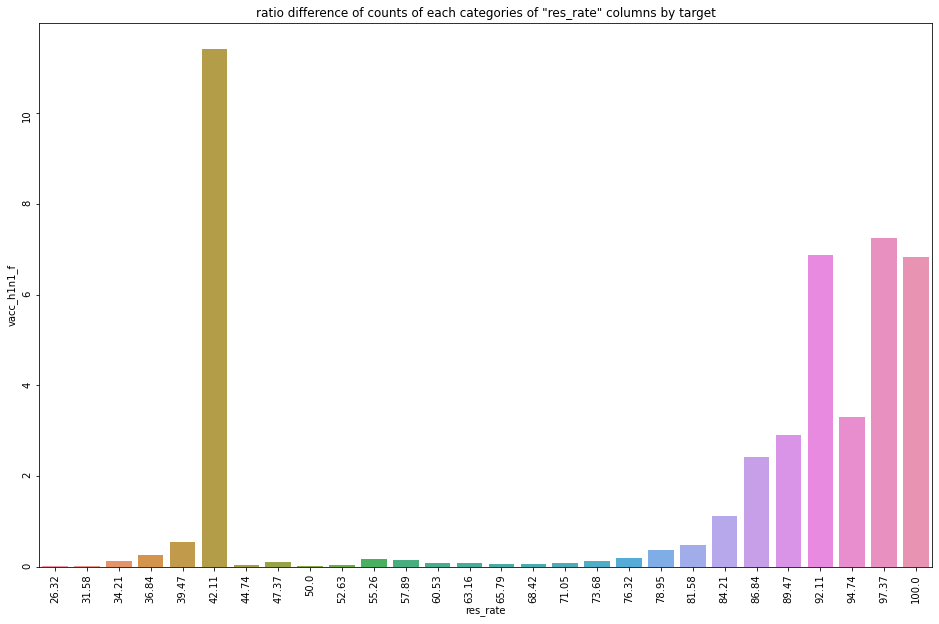

In [104]:
rdplot(df,'res_rate',rot=90)

In [105]:
#ProfileReport(df[df['res_rate']==42.11], title="42.11", explorative=True)

응답률 42.11%인 그룹은 10~20대가 거의 대부분이고 백신을 맞을 확률이 높다.그리고 이들은 습관 관련 설문을 하지 않았다. 또한 이들이 다른 변수의 결측치를 채움으로써 해당 변수들의 해당 항목 중요도를 올림. EDA할때 agegrp에서 둘이 합쳐서 13%로 제일 중요도 높았음

In [106]:
df.drop(['res_rate'],axis=1,inplace=True)

In [107]:
# n_adult_r + househole_childrn = n_people_r 임을 이용하여 결측치 채우기
# If there is one MV among them, we can fill the MV
# 1 MV detection(MVs have 'True')
a=(~df_MV['n_adult_r_mv'] * df_MV['household_children_mv'] * ~df_MV['n_people_r_mv'])+(df_MV['n_adult_r_mv'] * ~df_MV['household_children_mv'] * ~df_MV['n_people_r_mv'])+(~df_MV['n_adult_r_mv'] * ~df_MV['household_children_mv'] * df_MV['n_people_r_mv'])
a.unique()

C:\Users\gram\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
C:\Users\gram\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


array([False])

In [108]:
#가설검정을 통해 결측여부가 어떤 변수와 연관있는지 알아보기
for i in df_MV.columns:
    for j in df.columns:
        obs=pd.crosstab(df_MV[i],df[j])
        a=scipy.stats.chi2_contingency(obs,correction=False)[1]
        b=scipy.stats.chi2_contingency(obs,correction=True)[1]
        if a<0.05 or b<0.05:
            print(f'{i} and {j} are dependent')


h1n1_concern_mv and doctor_recc_h1n1 are dependent
h1n1_concern_mv and doctor_recc_seasonal are dependent
h1n1_concern_mv and chronic_med_condition are dependent
h1n1_concern_mv and health_insurance are dependent
h1n1_concern_mv and agegrp are dependent
h1n1_concern_mv and education_comp are dependent
h1n1_concern_mv and raceeth4_i are dependent
h1n1_concern_mv and sex_i are dependent
h1n1_concern_mv and inc_pov are dependent
h1n1_concern_mv and marital are dependent
h1n1_concern_mv and employment_status are dependent
h1n1_concern_mv and census_region are dependent
h1n1_concern_mv and census_msa are dependent
h1n1_concern_mv and n_adult_r are dependent
h1n1_concern_mv and household_children are dependent
h1n1_concern_mv and n_people_r are dependent
h1n1_concern_mv and employment_industry are dependent
h1n1_concern_mv and employment_occupation are dependent
h1n1_concern_mv and state are dependent
h1n1_concern_mv and vacc_h1n1_f are dependent
h1n1_concern_mv and vacc_seas_f are dependent

#### Handling MCAR

In [109]:
#IDK

#### etc

의사의 추천 결측값가진 1000몇개는 날려도 좋지 않을까? 아니면 높은 information을 가진 피쳐를 전부 결측한녀석이라던가

In [110]:
a=df_MV['doctor_recc_h1n1_mv'] * df_MV['opinion_h1n1_vacc_effective_mv']
a.value_counts()

C:\Users\gram\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


False    41500
True       654
dtype: int64

### Encoding categorical variables

In [111]:
#Binary encoder
binary_encoder=category_encoders.binary.BinaryEncoder(cols=categorical_encoding_needed,handle_missing='return_nan')
df_encode=binary_encoder.fit_transform(df)

### Multiple imputation

In [112]:
col_type={'h1n1_concern': 'B',
 'h1n1_knowledge': 'B',
 'behavioral_antiviral_meds': 'A',
 'behavioral_avoidance': 'A',
 'behavioral_face_mask': 'A',
 'behavioral_wash_hands': 'A',
 'behavioral_large_gatherings': 'A',
 'behavioral_outside_home': 'A',
 'behavioral_touch_face': 'A',
 'doctor_recc_h1n1': 'A',
 'doctor_recc_seasonal': 'A',
 'chronic_med_condition': 'A',
 'child_under_6_months': 'A',
 'health_insurance': 'A',
 'health_worker': 'A',
 'opinion_h1n1_vacc_effective': 'B',
 'opinion_h1n1_risk': 'B',
 'opinion_h1n1_sick_from_vacc': 'B',
 'opinion_seas_vacc_effective': 'B',
 'opinion_seas_risk': 'B',
 'opinion_seas_sick_from_vacc': 'B',
 'agegrp': 'B',
 'education_comp': 'B',
 'raceeth4_i_0': 'A',
 'raceeth4_i_1': 'A',
 'raceeth4_i_2': 'A',
 'sex_i': 'A',
 'inc_pov': 'B',
 'marital': 'A',
 'rent_own_r': 'A',
 'employment_status': 'B',
 'census_region_0': 'A',
 'census_region_1': 'A',
 'census_region_2': 'A',
 'census_msa': 'B',
 'n_adult_r': 'B',
 'household_children': 'B',
 'n_people_r': 'B',
 'employment_industry_0': 'A',
 'employment_industry_1': 'A',
 'employment_industry_2': 'A',
 'employment_industry_3': 'A',
 'employment_industry_4': 'A',
 'employment_occupation_0': 'A',
 'employment_occupation_1': 'A',
 'employment_occupation_2': 'A',
 'employment_occupation_3': 'A',
 'employment_occupation_4': 'A',
 'hhs_region_0': 'A',
 'hhs_region_1': 'A',
 'hhs_region_2': 'A',
 'hhs_region_3': 'A',
 'state_0': 'A',
 'state_1': 'A',
 'state_2': 'A',
 'state_3': 'A',
 'state_4': 'A',
 'state_5': 'A'}

In [113]:
try:
    targets=df_encode[['vacc_seas_f','vacc_h1n1_f']]
    df_encode.drop(['vacc_h1n1_f','vacc_seas_f'],axis=1,inplace=True)
except:
    pass
strategies=['default predictive', 'least squares', 'stochastic', 'binary logistic', 'multinomial logistic', 'bayesian least squares', 'bayesian binary logistic', 'pmm', 'lrd', 'default univariate', 'default time', 'mean', 'median', 'mode', 'random', 'norm', 'categorical', 'interpolate', 'locf', 'nocb', 'normal unit variance']

for i in itertools.combinations(strategies,2):
    input_strategy1={}
    input_strategy2={}
    for j in col_type:
        if col_type[j]=='A':
            input_strategy1[j]=i[0]
            input_strategy2[j]=i[1]
        else:
            input_strategy1[j]=i[1]
            input_strategy2[j]=i[0]
            
    try:
        mice = MiceImputer(strategy=input_strategy1, return_list=True)
        mice.fit_transform(df_encode)
        print(col_type)
    except Exception as e:
        print(e)
    try:
        mice = MiceImputer(strategy=input_strategy2, return_list=True)
        mice.fit_transform(df_encode)
        print(col_type)
    except Exception as e:
        print(e)

C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached whi

least squares not appropriate for Series employment_status of type object.
least squares not appropriate for Series behavioral_antiviral_meds of type object.


C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached whi

stochastic not appropriate for Series employment_status of type object.
stochastic not appropriate for Series behavioral_antiviral_meds of type object.
Binary requires 2 categories. Use multinomial instead.


C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnin

Chain 3 failed.


C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary i

X has 46 features per sample; expecting 57


C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached whi

In [114]:
try:
    df_encode.drop(['vacc_seas_f'],axis=1,inplace=True)
except:
    pass

import itertools
for cols in itertools.combinations(df_encode.columns,3):
    cols=list(cols)
    a=df_encode[cols]
    mice_strategy={}
    for column in a.columns:
        if a.dtypes.to_dict()[column]=='bool':
            mice_strategy[column]= 'binary logistic'
        else:
            mice_strategy[column]= 'pmm'
    try:
        print(cols)
        mice = MiceImputer(strategy=mice_strategy, imp_kwgs={"pmm": {"fill_value": "random"}}, visit="left-to-right", return_list=True)
        mice.fit_transform(a)
        print(1)
    except:
        print(0)

['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds']
0
['h1n1_concern', 'h1n1_knowledge', 'behavioral_avoidance']
0
['h1n1_concern', 'h1n1_knowledge', 'behavioral_face_mask']
0
['h1n1_concern', 'h1n1_knowledge', 'behavioral_wash_hands']
0
['h1n1_concern', 'h1n1_knowledge', 'behavioral_large_gatherings']
0
['h1n1_concern', 'h1n1_knowledge', 'behavioral_outside_home']
0
['h1n1_concern', 'h1n1_knowledge', 'behavioral_touch_face']
0
['h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1']
0
['h1n1_concern', 'h1n1_knowledge', 'doctor_recc_seasonal']
0
['h1n1_concern', 'h1n1_knowledge', 'chronic_med_condition']
0
['h1n1_concern', 'h1n1_knowledge', 'child_under_6_months']
0
['h1n1_concern', 'h1n1_knowledge', 'health_insurance']
0
['h1n1_concern', 'h1n1_knowledge', 'health_worker']
0
['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective']


C:\Users\gram\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\gram\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\gram\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\gram\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, beta, alpha]


### Outliers

I replaced some Outliers with Null while EDA1 (feature : 'rent_own_r')

### Scaling

### Upsampling unbalanced Data

### EDA2

##### Pandas Profiling

In [ ]:
ProfileReport(df, title="Pandas Profiling Report", explorative=True)

Render HTML: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


### Clustering

In [ ]:
난관. 할게많다

NameError: name '난관' is not defined

### Derive variables

### Feature Selection by filter methods

In [ ]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)
        
        if round(d['IV'].sum(),6)>0.5:
          print('***********************************found************************')

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [ ]:
iv, woe = iv_woe(data = df, target = 'vacc_h1n1_f', bins=10, show_woe = True)
print(iv)
print(woe)

Information value of h1n1_concern is 0.079903
       Variable         Cutoff      N  Events  % of Events  Non-Events  \
0  h1n1_concern  (-0.001, 1.0]  14502    2352     0.330616       12150   
1  h1n1_concern     (1.0, 2.0]  13441    3083     0.433371       10358   
2  h1n1_concern     (2.0, 3.0]   5791    1679     0.236013        4112   

   % of Non-Events       WoE        IV  
0         0.456424 -0.322465  0.040569  
1         0.389106  0.107742  0.004769  
2         0.154470  0.423887  0.034565  
Information value of h1n1_knowledge is 0.085543
         Variable         Cutoff      N  Events  % of Events  Non-Events  \
0  h1n1_knowledge  (-0.001, 1.0]  21732    3783     0.531768       17949   
1  h1n1_knowledge     (1.0, 2.0]  12002    3331     0.468232        8671   

   % of Non-Events       WoE        IV  
0         0.674267 -0.237419  0.033832  
1         0.325733  0.362887  0.051711  
Information value of behavioral_antiviral_meds is 0.011504
                    Variable  Cuto

### Dimension Reduction

### Split data

### baseline model and 1th analysis

### Evaluation 1

### Feature engineering and 2nd analysis

### Evaluation 2

### Conclusion